In [2]:
import numpy as np
import scipy
import matplotlib
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from math import *
import random

import warnings #to ignore the runtimewarnings when fitting Hill
warnings.filterwarnings("ignore")

To do:
- Interprete the graphs from nH vs parameter changed. Does it make sense that when we increase raf1, the general pathway becomes more steeper. I think that when there is more raf1, it could be more transferred to raf1star, and so there is more enzyme that could activate mek etc. When for example there is more mekpase and erkpase, there will be more dephosphorylation of activated mek & erk, slowing down the pathway. (check)
- Do logspace instead of linspace when changing parameters (better to study the parameterspace) (check)
- Calculate the same probabilities for Kerk (in units of rastot (0.01) (check)
- When making the intervals in LHS, do more combinations and then lower amount when actually choosing the random_samples, so that we can pick. (check)
- Try to scan the parameter space locally, to see whether there is much variation locally --> if not, then don't include this in the paper but maybe mention it (material & methods).
- Try to find parameters so that nH = 2 and Kerk = 0.5 --> How to determine how "easy" it was? Maybe expanding the parameterspace and calculate the chances again. An expansion of maybe 300% --> Lowest value and highest value times 300% and that are the new bounds of the space? Then calculate probabilities again, and then we can say "if the parameter space from Xenopus laevus was expanded by 300%, the chance to get a Hill Coefficient of 2 in the ascidian embryo is increased by ... (same for Kerk)"
- Clean up the code, check everything and then upload it on GitHub
- Find about the odeint method --> Maybe find another module where Euler is used? 

# The Basic model from Huang & Ferrell

![Mapkmodel](figures/mapkfig.png)

In [3]:
#Total values of enzymes and proteins

raf1tot = 0.003

rastot = 0.001
e2tot = 0.0003

mektot = 1.2
mekpasetot = 0.0003

erktot = 1.2
erkpasetot = 0.12


#values of the a, d and k, taken from the article by Huang & Ferrell. 

a = 1000

d = 150

k = 150

params_rate = [rastot, raf1tot, e2tot, mektot, mekpasetot, erktot, erkpasetot, a, d, k]

In [4]:
variables = ['RAF1', 'RAF1_Ras', 'RAF1*','RAF1*_E2', 'MEK', 'MEK_RAF1*','pMEK', "pMEK_MEK-P'ase", 'dpMEK', 'ERK','ERK_dpMEK','pERK','pERK_dpMEK',"pERK_ERK-P'ase",'dpERK',"dpERK_ERK-P'ase"] 

In [5]:
def mapkmodel(x, t, params=params_rate):
    #dissolve the x-vector into the parameters, to avoid confusion
    raf1, raf1_ras, raf1star, raf1star_e2 = x[0], x[1], x[2], x[3]
    mek, mek_raf1star = x[4], x[5]
    pmek, pmek_mekpase = x[6], x[7]
    dpmek = x[8]
    erk, erk_dpmek = x[9], x[10]
    perk, perk_dpmek, perk_erkpase = x[11], x[12], x[13]
    dperk, dperk_erkpase = x[14], x[15]
    
    # 'Dissolve' the parameter array: 
    rastot, raf1tot, e2tot, mektot, mekpasetot, erktot, erkpasetot, a, d, k = params
    
    
    #use 6 conservation equations, I choose pmek_raf1star, dpmek_mekpase and to be fixated.
    pmek_raf1star = raf1tot - raf1 - raf1star - raf1_ras - raf1star_e2 - mek_raf1star
    dpmek_mekpase = mektot - mek - pmek - dpmek - mek_raf1star - pmek_raf1star - pmek_mekpase - erk_dpmek - perk_dpmek
    ras = rastot - raf1_ras
    e2 = e2tot - raf1star_e2
    mekpase = mekpasetot - pmek_mekpase - dpmek_mekpase
    erkpase = erkpasetot - perk_erkpase - dperk_erkpase
    
  
    #Differential Equations, removed the ones for pmek_raf1star & dpmek_mekpase
    
    Draf1 = (d * raf1_ras) + (k * raf1star_e2) - (a * raf1 * ras)
    
    Draf1_ras = (a * raf1 * ras) - ((d + k)*raf1_ras)
    
    Draf1star = (k * raf1_ras) - (a * raf1star * e2) + (d * raf1star_e2) - (a * mek * raf1star) + ((d + k) * mek_raf1star) - (a * pmek * raf1star) + ((k+d) * pmek_raf1star)
    
    Draf1star_e2 = (a * raf1star * e2) - ((d + k) * raf1star_e2)
    
    Dmek = (d * mek_raf1star) + (k * pmek_mekpase) - (a * mek * raf1star)
    
    Dmek_raf1star = (a * mek * raf1star) - ((d + k) * mek_raf1star)
    
    Dpmek = (k * mek_raf1star) + (d * pmek_mekpase) - (a * pmek * mekpase) - (a * pmek * raf1star) + (d * pmek_raf1star) + (k * dpmek_mekpase)
    
    #Dpmek_raf1star = (a * pmek * raf1star) - ((d + k) * pmek_raf1star)
    
    Dpmek_mekpase = (a * pmek * mekpase) - ((d + k) * pmek_mekpase)
    
    Ddpmek = (k * pmek_raf1star) - (a * dpmek * mekpase) + (d * dpmek_mekpase) - (a * erk * dpmek) + ((d + k) * erk_dpmek) - (a * perk * dpmek) + ((d + k) * perk_dpmek)
    
    #Ddpmek_mekpase = (a * dpmek * mekpase) - ((d + k) * dpmek_mekpase)
    
    Derk = (d * erk_dpmek) + (k * perk_erkpase) - (a * erk * dpmek)
    
    Derk_dpmek = (a * erk * dpmek) - ((d + k) * erk_dpmek)
    
    Dperk = (k * erk_dpmek) - (a * perk * erkpase) + (d * perk_erkpase) - (a * perk * dpmek) + (d * perk_dpmek) + (k * dperk_erkpase)
    
    Dperk_dpmek = (a * perk * dpmek) - ((d + k) * perk_dpmek)
    
    Dperk_erkpase = (a * perk * erkpase) - ((d + k) * perk_erkpase)
    
    Ddperk = (k * perk_dpmek) - (a * dperk * erkpase) + (d * dperk_erkpase)
    
    Ddperk_erkpase = (a * dperk * erkpase) - ((d + k) * dperk_erkpase)
    
    return np.array([Draf1, Draf1_ras, Draf1star, Draf1star_e2, Dmek, Dmek_raf1star, Dpmek, Dpmek_mekpase, Ddpmek, Derk, Derk_dpmek, Dperk, Dperk_dpmek, Dperk_erkpase, Ddperk, Ddperk_erkpase])
    

In [6]:
#initial values:

e2_0 = e2tot
mekpase_0 = mekpasetot
erkpase_0 = erkpasetot

raf1_0 = raf1tot
raf1_ras_0 = 0
raf1star_0 = 0
raf1star_e2_0 = 0

mek_0 = mektot
mek_raf1star_0 = 0
pmek_0 = 0
pmek_mekpase_0 = 0

pmek_raf1star_0 = 0
dpmek_0 = 0
dpmek_mekpase_0 = 0

erk_0 = erktot
erk_dpmek_0 = 0
perk_0 = 0
perk_erkpase_0 = 0
perk_dpmek_0 = 0
dperk_0 = 0
dperk_erkpase_0 = 0

initial_values = np.array([raf1_0, raf1_ras_0, raf1star_0, raf1star_e2_0, mek_0, mek_raf1star_0, pmek_0, pmek_mekpase_0, dpmek_0, erk_0, erk_dpmek_0, perk_0, perk_dpmek_0, perk_erkpase_0, dperk_0, dperk_erkpase_0])

In [7]:
t = np.linspace(0, 1000, num=100000)
#print(t)

In [8]:
tend = int(len(t)/10/2)

In [326]:
solutions = odeint(mapkmodel, initial_values, t, args= (params_rate,))
np.savetxt("solutions.txt", solutions)

In [9]:
solutions_load = np.loadtxt('solutions.txt')

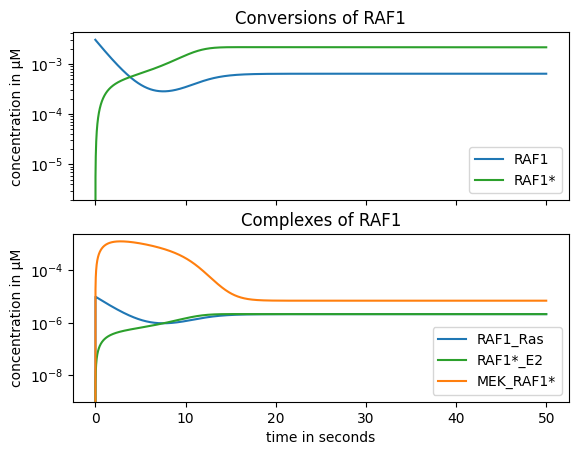

In [10]:
fig, axs = plt.subplots(2,1)
axs[0].plot(t[0:tend], solutions_load[0:tend,0], "tab:blue", label = variables[0])
axs[0].plot(t[0:tend], solutions_load[0:tend,2],  "tab:green", label = variables[2])
axs[0].set_title("Conversions of RAF1")
axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(t[0:tend], solutions_load[0:tend,1], "tab:blue", label = variables[1])
axs[1].plot(t[0:tend], solutions_load[0:tend,3], "tab:green", label = variables[3])
axs[1].plot(t[0:tend], solutions_load[0:tend,5], "tab:orange", label = variables[5])
axs[1].set_title("Complexes of RAF1")
axs[1].set_yscale("log")
axs[1].legend()

for ax in axs.flat:
    ax.set(xlabel = "time in seconds", ylabel = "concentration in µM")
    ax.label_outer()


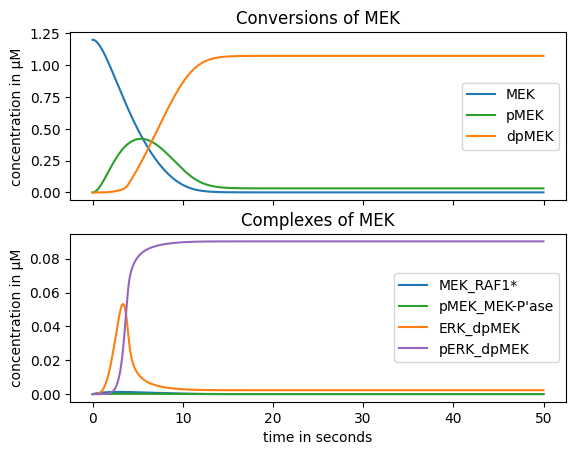

In [11]:
fig, axs = plt.subplots(2,1)
axs[0].plot(t[0:tend], solutions_load[0:tend,4], "tab:blue", label = variables[4])
axs[0].plot(t[0:tend], solutions_load[0:tend,6], "tab:green", label = variables[6])
axs[0].plot(t[0:tend], solutions_load[0:tend,8], "tab:orange", label = variables[8])
axs[0].set_title("Conversions of MEK")
#axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(t[0:tend], solutions_load[0:tend,5], "tab:blue", label = variables[5])
axs[1].plot(t[0:tend], solutions_load[0:tend,7], "tab:green", label = variables[7])
axs[1].plot(t[0:tend], solutions_load[0:tend,10], "tab:orange", label = variables[10])
axs[1].plot(t[0:tend], solutions_load[0:tend,12], "tab:purple", label = variables[12])
axs[1].set_title("Complexes of MEK")
#axs[1].set_yscale("log")
axs[1].legend()

for ax in axs.flat:
    ax.set(xlabel = "time in seconds", ylabel = "concentration in µM")
    ax.label_outer()

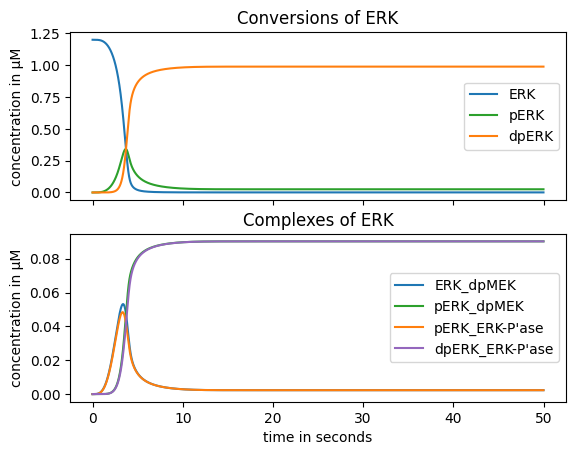

In [12]:
fig, axs = plt.subplots(2,1)
axs[0].plot(t[0:tend], solutions_load[0:tend,9], "tab:blue", label = variables[9])
axs[0].plot(t[0:tend], solutions_load[0:tend,11], "tab:green", label = variables[11])
axs[0].plot(t[0:tend], solutions_load[0:tend,14], "tab:orange", label = variables[14])
axs[0].set_title("Conversions of ERK")
#axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(t[0:tend], solutions_load[0:tend,10], "tab:blue", label = variables[10])
axs[1].plot(t[0:tend], solutions_load[0:tend,12], "tab:green", label = variables[12])
axs[1].plot(t[0:tend], solutions_load[0:tend,13], "tab:orange", label = variables[13])
axs[1].plot(t[0:tend], solutions_load[0:tend,15], "tab:purple", label = variables[15])
axs[1].set_title("Complexes of ERK")
#axs[1].set_yscale("log")
axs[1].legend()

for ax in axs.flat:
    ax.set(xlabel = "time in seconds", ylabel = "concentration in µM")
    ax.label_outer()

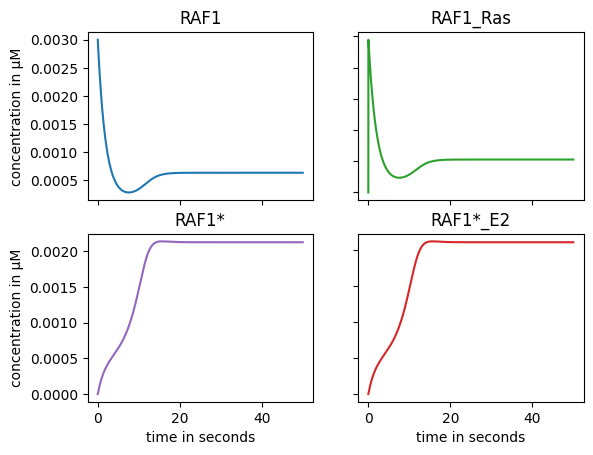

In [13]:
fig, axs = plt.subplots(2,2)
axs[0,0].plot(t[0:tend], solutions_load[0:tend,0])
axs[0,0].set_title(variables[0])
axs[0,1].plot(t[0:tend], solutions_load[0:tend,1], "tab:green")
axs[0,1].set_title(variables[1])
axs[1,0].plot(t[0:tend], solutions_load[0:tend,2], "tab:purple")
axs[1,0].set_title(variables[2])
axs[1,1].plot(t[0:tend], solutions_load[0:tend,3], "tab:red")
axs[1,1].set_title(variables[3])

for ax in axs.flat:
    ax.set(xlabel = "time in seconds", ylabel = "concentration in µM")
    ax.label_outer()

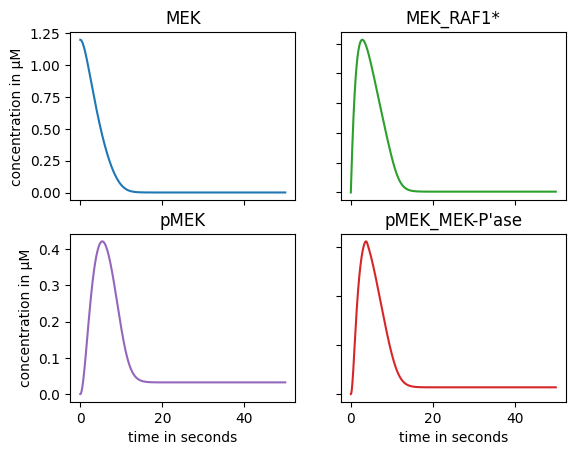

In [14]:
fig2, axs2 = plt.subplots(2,2)
axs2[0,0].plot(t[0:tend], solutions_load[0:tend,4])
axs2[0,0].set_title(variables[4])
axs2[0,1].plot(t[0:tend], solutions_load[0:tend,5], "tab:green")
axs2[0,1].set_title(variables[5])
axs2[1,0].plot(t[0:tend], solutions_load[0:tend,6], "tab:purple")
axs2[1,0].set_title(variables[6])
axs2[1,1].plot(t[0:tend], solutions_load[0:tend,7], "tab:red")
axs2[1,1].set_title(variables[7])

for ax in axs2.flat:
    ax.set(xlabel = "time in seconds", ylabel = "concentration in µM")
    ax.label_outer()

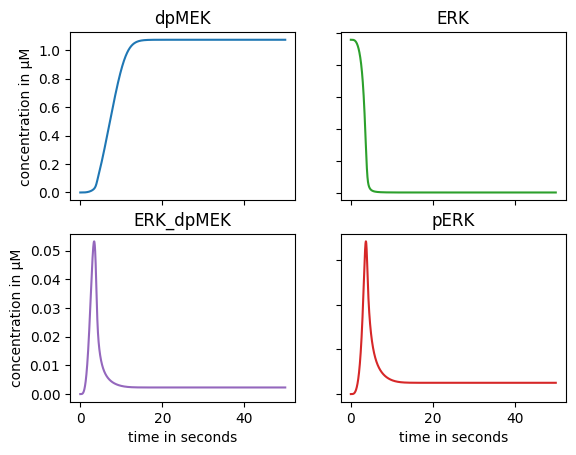

In [15]:
fig3, axs3 = plt.subplots(2,2)
axs3[0,0].plot(t[0:tend], solutions_load[0:tend,8])
axs3[0,0].set_title(variables[8])
axs3[0,1].plot(t[0:tend], solutions_load[0:tend,9], "tab:green")
axs3[0,1].set_title(variables[9])
axs3[1,0].plot(t[0:tend], solutions_load[0:tend,10], "tab:purple")
axs3[1,0].set_title(variables[10])
axs3[1,1].plot(t[0:tend], solutions_load[0:tend,11], "tab:red")
axs3[1,1].set_title(variables[11])


for ax in axs3.flat:
    ax.set(xlabel = "time in seconds", ylabel = "concentration in µM")
    ax.label_outer()

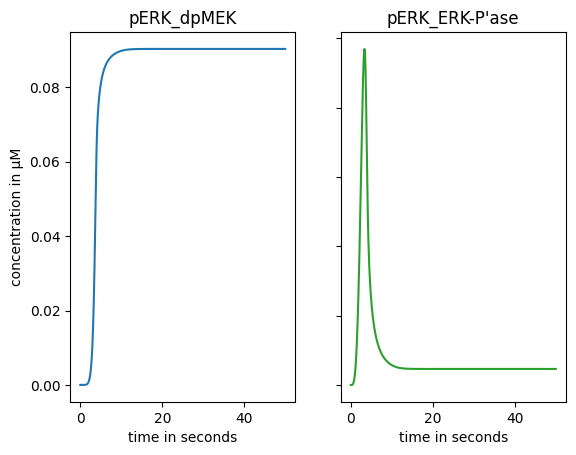

In [16]:
fig4, axs4 = plt.subplots(1,2)
axs4[0].plot(t[0:tend], solutions_load[0:tend,12])
axs4[0].set_title(variables[12])
axs4[1].plot(t[0:tend], solutions_load[0:tend,13], "tab:green")
axs4[1].set_title(variables[13])

for ax in axs4.flat:
    ax.set(xlabel = "time in seconds", ylabel = "concentration in µM")
    ax.label_outer()

Text(0, 0.5, 'concentration in µM')

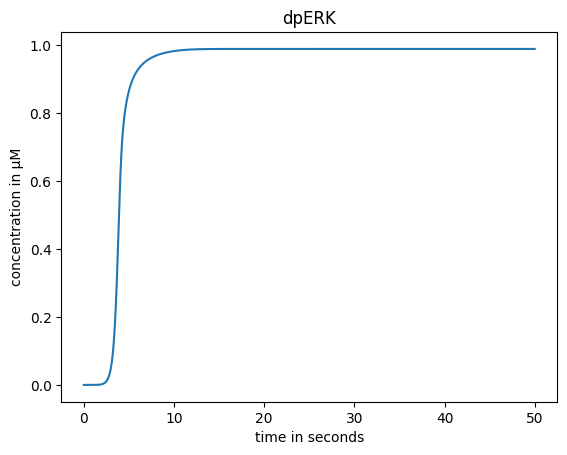

In [17]:
plt.plot(t[0:tend], solutions_load[0:tend,14])
plt.title(variables[14])
plt.xlabel("time in seconds")
plt.ylabel("concentration in µM")

When altering the value of rastot, we can find the steady-state value of dperk in the graph.


In [23]:
#interval_values = [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01]
interval_values = np.logspace(-8, -2, 100, base = 10)
print(interval_values)
dperk_values = []
list(interval_values)
erk_values = []

[1.00000000e-08 1.14975700e-08 1.32194115e-08 1.51991108e-08
 1.74752840e-08 2.00923300e-08 2.31012970e-08 2.65608778e-08
 3.05385551e-08 3.51119173e-08 4.03701726e-08 4.64158883e-08
 5.33669923e-08 6.13590727e-08 7.05480231e-08 8.11130831e-08
 9.32603347e-08 1.07226722e-07 1.23284674e-07 1.41747416e-07
 1.62975083e-07 1.87381742e-07 2.15443469e-07 2.47707636e-07
 2.84803587e-07 3.27454916e-07 3.76493581e-07 4.32876128e-07
 4.97702356e-07 5.72236766e-07 6.57933225e-07 7.56463328e-07
 8.69749003e-07 1.00000000e-06 1.14975700e-06 1.32194115e-06
 1.51991108e-06 1.74752840e-06 2.00923300e-06 2.31012970e-06
 2.65608778e-06 3.05385551e-06 3.51119173e-06 4.03701726e-06
 4.64158883e-06 5.33669923e-06 6.13590727e-06 7.05480231e-06
 8.11130831e-06 9.32603347e-06 1.07226722e-05 1.23284674e-05
 1.41747416e-05 1.62975083e-05 1.87381742e-05 2.15443469e-05
 2.47707636e-05 2.84803587e-05 3.27454916e-05 3.76493581e-05
 4.32876128e-05 4.97702356e-05 5.72236766e-05 6.57933225e-05
 7.56463328e-05 8.697490

In [337]:
for i in interval_values:
    params_rate[0] = i
    solutions = odeint(mapkmodel, initial_values, t, args= (params_rate,))
    dperk_values.append(solutions[:,14][-1])
np.savetxt('dperk_values.txt', dperk_values)

In [18]:
dperk_values_load = np.loadtxt('dperk_values.txt')

In [19]:
rastot = 10**-5
solutions = odeint(mapkmodel, initial_values, t, args = (params_rate,))
new_erk = solutions[:,14]
erk_value = new_erk[-1]
print(erk_value)
#list(dperk_values)

0.9889116082730854


In [20]:
def Erk_ifo_erktot(erklist):
    totvalue = erktot
    new_erk_list = []
    for i in erklist:
        erk_n = i / params_rate[5]
        new_erk_list.append(erk_n)
    return new_erk_list

In [21]:
dperktot_values = Erk_ifo_erktot(dperk_values_load)

Text(0.5, 1.0, 'dpERK in function of Ras-GTP from the model')

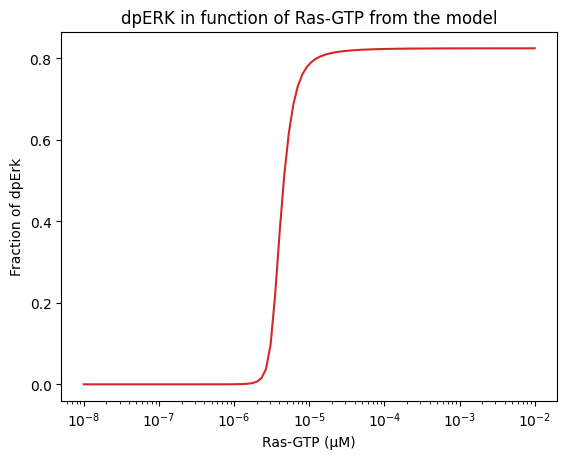

In [24]:
plt.plot(interval_values, dperktot_values , 'tab:red')
plt.xlabel("Ras-GTP (µM)")
plt.ylabel("Fraction of dpErk")
plt.xscale('log')
plt.title("dpERK in function of Ras-GTP from the model")

## Fitting with different functions

In [25]:
def Michaelis_Menten(x, a, b):
    return (a * x)/(x+b)

def Sigmoid(x, a, b, c, d):
    return a / ( b + c * np.exp(-d*x))

def Hill(x, a, b, c):
    return c * x ** a / (x**a + b**a)

In [26]:
params, pcov = curve_fit(Michaelis_Menten, interval_values, dperktot_values)
params2, pcov2 = curve_fit(Sigmoid, interval_values, dperktot_values)
params3, pcov3 = curve_fit(Hill, interval_values, dperktot_values)

In [27]:
residualsMM = dperktot_values - Michaelis_Menten(interval_values, params[0], params[1])
ss_resMM = np.sum(residualsMM ** 2)
ss_totMM = np.sum((dperktot_values - np.mean(dperktot_values)) ** 2)
rsquaredMM = 1 - (ss_resMM / ss_totMM)

residualsSIG = dperktot_values - Sigmoid(interval_values, params2[0], params2[1], params2[2], params2[3])
ss_resSIG = np.sum(residualsSIG ** 2)
ss_totSIG = np.sum((dperktot_values - np.mean(dperktot_values)) ** 2)
rsquaredSIG = 1 - (ss_resSIG / ss_totSIG)

residualsHIL = dperktot_values - Hill(interval_values, params3[0], params3[1], params3[2])
ss_resHIL = np.sum(residualsHIL ** 2)
ss_totHIL = np.sum((dperktot_values - np.mean(dperktot_values)) ** 2)
rsquaredHIL = 1 - (ss_resHIL / ss_totHIL)

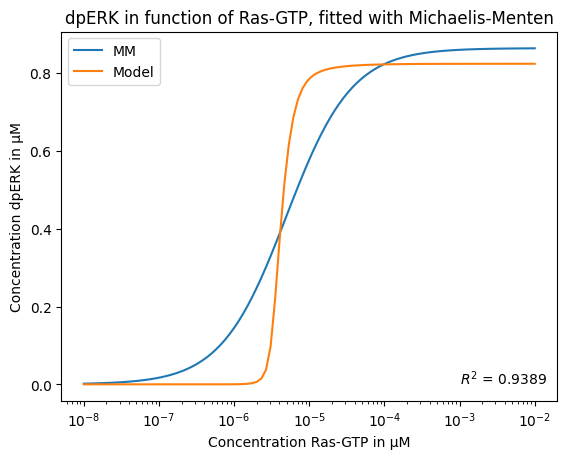

In [28]:
plt.plot(interval_values, Michaelis_Menten(interval_values, params[0], params[1]), label = "MM")
plt.plot(interval_values, dperktot_values, "tab:orange", label = "Model")
plt.xscale("log")
plt.xlabel("Concentration Ras-GTP in µM")
plt.ylabel("Concentration dpERK in µM")
plt.title("dpERK in function of Ras-GTP, fitted with Michaelis-Menten")
plt.annotate("$R^2$ = {}".format(round(rsquaredMM, 4)), (0.001, 0))
plt.legend()

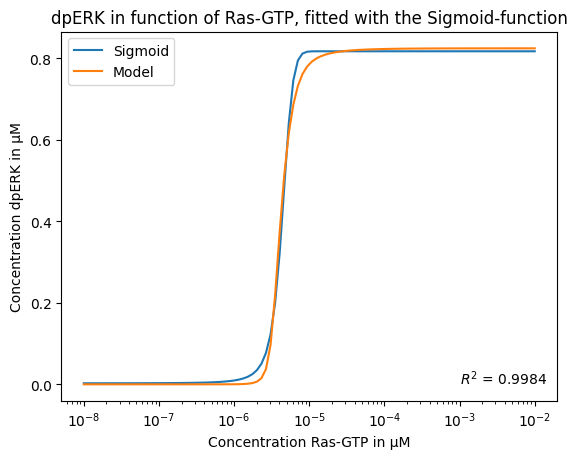

In [29]:
plt.plot(interval_values, Sigmoid(interval_values, params2[0], params2[1], params2[2], params2[3]), label = "Sigmoid")
plt.plot(interval_values, dperktot_values, "tab:orange", label = "Model")
plt.xscale("log")
plt.xlabel("Concentration Ras-GTP in µM")
plt.ylabel("Concentration dpERK in µM")
plt.title("dpERK in function of Ras-GTP, fitted with the Sigmoid-function")
plt.annotate("$R^2$ = {}".format(round(rsquaredSIG, 4)), (0.001, 0))
plt.legend()

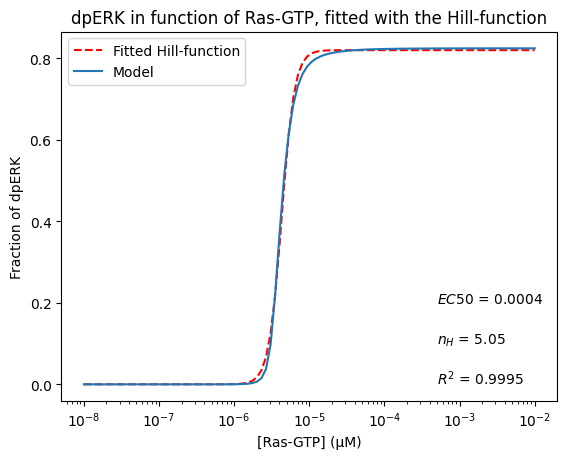

In [30]:
aaaa = round(params3[0], 2)
plt.plot(interval_values, Hill(interval_values, params3[0], params3[1], params3[2]), "r--", label = "Fitted Hill-function")
plt.plot(interval_values, dperktot_values, "tab:blue", label = "Model")
plt.xscale("log")
plt.xlabel("[Ras-GTP] (µM)")
plt.ylabel("Fraction of dpERK")
plt.title("dpERK in function of Ras-GTP, fitted with the Hill-function")
plt.annotate("$R^2$ = {}".format(round(rsquaredHIL, 4)), (0.0005, 0))
plt.annotate("$n_H$ = {}".format(aaaa), (0.0005, 0.1))
plt.annotate("$EC50$ = {}".format(round(params3[1]/0.01, 4)), (0.0005, 0.2))
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

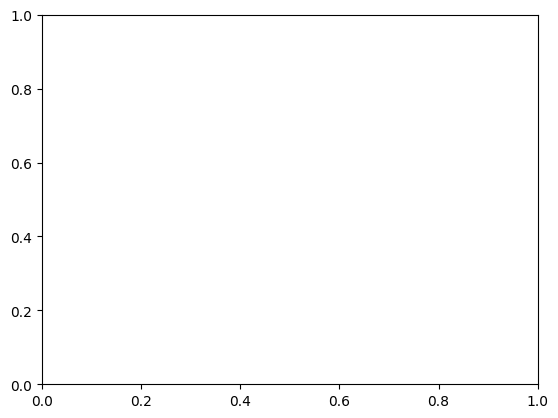

In [31]:
plt.plot(interval_values, dperk_values, 'r', label = "from model")
plt.plot(interval_values, Michaelis_Menten(interval_values, params[0], params[1]), label = "fitted with Michaelis-Menten")
plt.plot(interval_values, Sigmoid(interval_values, params2[0], params2[1], params2[2], params2[3]), "tab:green", label = "fitted with Sigmoid equation")
plt.plot(interval_values, Hill(interval_values, params3[0], params3[1], params3[2]), "tab:orange", label = "fitted with Hill-function")
plt.xlabel("Ras-GTP")
plt.ylabel("dpErk")
plt.xscale('log')
plt.legend()

## Check if steady-state has been reached in all cases

In [32]:
values = [10**i for i in range(-8, 0, 1)]
print(values)
check_values = []

[1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]


In [33]:
for i in values:
    rastot = i
    solutions1 = odeint(mapkmodel, initial_values, t, args=(params_rate,))
    check_values.append(solutions1[:,14])
    

Text(0.5, 1.0, 'Ras-GTP = 10^-8')

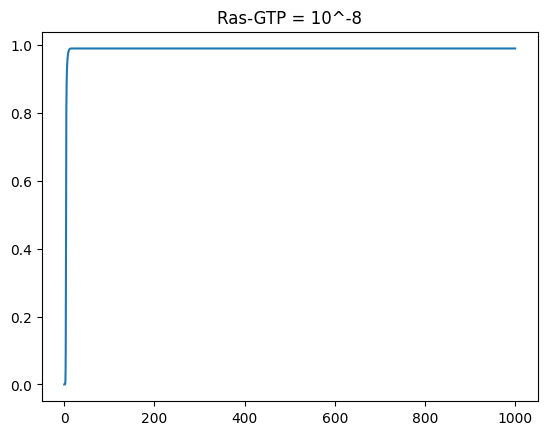

In [34]:
plt.plot(t, check_values[0])
plt.title("Ras-GTP = 10^-8")

Text(0.5, 1.0, 'Ras-GTP = 10^-7')

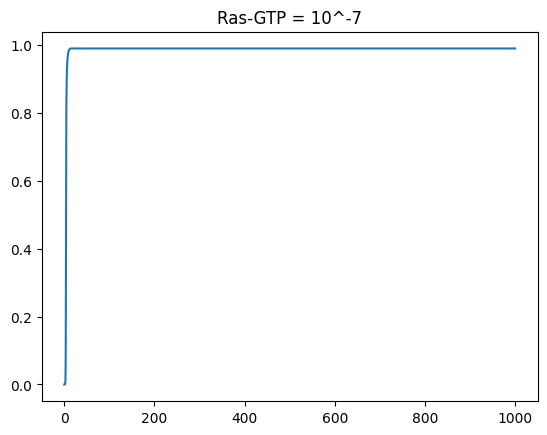

In [35]:
plt.plot(t, check_values[1])
plt.title("Ras-GTP = 10^-7")

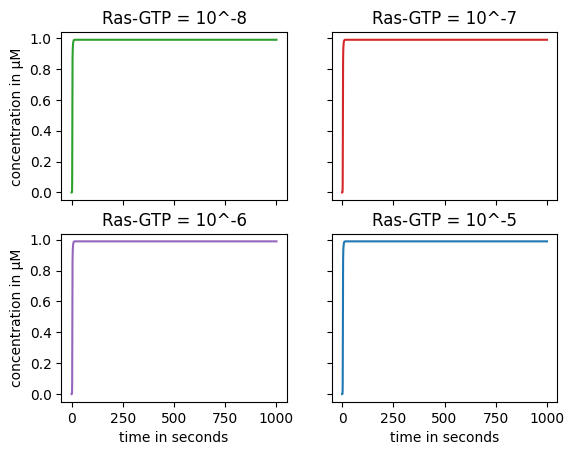

In [36]:
fig5, axs5 = plt.subplots(2,2)
axs5[0,0].plot(t, check_values[0], "tab:green")
axs5[0,0].set_title("Ras-GTP = 10^-8")
axs5[0,1].plot(t, check_values[1], "tab:red")
axs5[0,1].set_title("Ras-GTP = 10^-7")
axs5[1,0].plot(t, check_values[2], "tab:purple")
axs5[1,0].set_title("Ras-GTP = 10^-6")
axs5[1,1].plot(t, check_values[3], "tab:blue")
axs5[1,1].set_title("Ras-GTP = 10^-5")

for ax in axs5.flat:
    ax.set(xlabel = "time in seconds", ylabel = "concentration in µM")
    ax.label_outer()

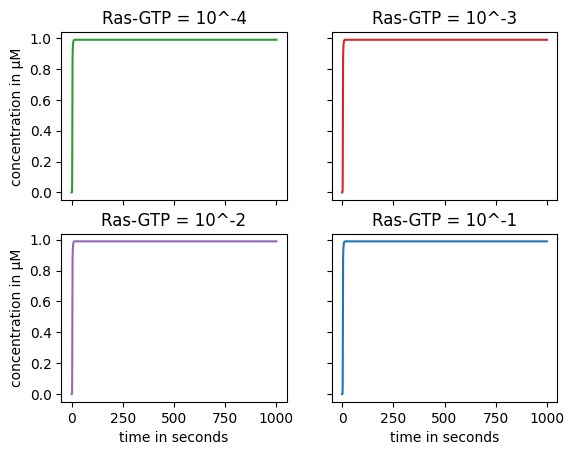

In [37]:
fig6, axs6 = plt.subplots(2,2)
axs6[0,0].plot(t, check_values[4], "tab:green")
axs6[0,0].set_title("Ras-GTP = 10^-4")
axs6[0,1].plot(t, check_values[5], "tab:red")
axs6[0,1].set_title("Ras-GTP = 10^-3")
axs6[1,0].plot(t, check_values[6], "tab:purple")
axs6[1,0].set_title("Ras-GTP = 10^-2")
axs6[1,1].plot(t, check_values[7], "tab:blue")
axs6[1,1].set_title("Ras-GTP = 10^-1")

for ax in axs6.flat:
    ax.set(xlabel = "time in seconds", ylabel = "concentration in µM")
    ax.label_outer()

At every concentration of rastot, steady-state will be reached (after 1000 seconds).

# Parameter Space Exploration: Varying 1 parameter

In [38]:
raf1interval = [0.0006, 0.003, 0.015]
mekinterval = [0.24, 1.2, 6]
erkinterval = [0.24, 1.2, 6]
e2interval = [0.00006, 0.0003, 0.0015]
mekpaseinterval = [0.00006, 0.0003, 0.0015]
erkpaseinterval = [0.024, 0.12, 0.6]

raf1intervallog = np.logspace((np.log(0.0006) / np.log(10)) , np.log(0.015) / np.log(10), num = 100)
mekintervallog = np.logspace((np.log(0.24) / np.log(10)) , np.log(6) / np.log(10), num = 100)
erkintervallog = np.logspace((np.log(0.24) / np.log(10)) , np.log(6) / np.log(10), num = 100)
e2intervallog = np.logspace((np.log(0.00006) / np.log(10)) , np.log(0.0015) / np.log(10), num = 100)
mekpaseintervallog = np.logspace((np.log(0.00006) / np.log(10)) , np.log(0.0015) / np.log(10), num = 100)
erkpaseintervallog = np.logspace((np.log(0.024) / np.log(10)) , np.log(0.6) / np.log(10), num = 100)



#interval_values = np.logspace(-8, -2, 100, base = 10)

In [39]:
raf1intervallog

array([0.0006    , 0.00061983, 0.00064031, 0.00066147, 0.00068334,
       0.00070592, 0.00072925, 0.00075335, 0.00077824, 0.00080396,
       0.00083053, 0.00085798, 0.00088634, 0.00091563, 0.00094589,
       0.00097715, 0.00100944, 0.0010428 , 0.00107726, 0.00111287,
       0.00114964, 0.00118764, 0.00122689, 0.00126743, 0.00130932,
       0.00135259, 0.00139729, 0.00144347, 0.00149117, 0.00154045,
       0.00159136, 0.00164396, 0.00169829, 0.00175441, 0.00181239,
       0.00187229, 0.00193416, 0.00199808, 0.00206412, 0.00213233,
       0.0022028 , 0.0022756 , 0.00235081, 0.0024285 , 0.00250875,
       0.00259166, 0.00267731, 0.00276579, 0.0028572 , 0.00295162,
       0.00304917, 0.00314994, 0.00325404, 0.00336158, 0.00347267,
       0.00358744, 0.003706  , 0.00382847, 0.003955  , 0.00408571,
       0.00422073, 0.00436022, 0.00450432, 0.00465318, 0.00480695,
       0.00496582, 0.00512993, 0.00529946, 0.0054746 , 0.00565553,
       0.00584243, 0.00603551, 0.00623498, 0.00644103, 0.00665

In [40]:
def reset_initial_values(parameters):
    e2_0 = parameters[2]
    mekpase_0 = parameters[4]
    erkpase_0 = parameters[6]

    raf1_0 = parameters[1]
    raf1_ras_0 = 0
    raf1star_0 = 0
    raf1star_e2_0 = 0

    mek_0 = parameters[3]
    mek_raf1star_0 = 0
    pmek_0 = 0
    pmek_mekpase_0 = 0

    pmek_raf1star_0 = 0
    dpmek_0 = 0
    dpmek_mekpase_0 = 0

    erk_0 = parameters[5]
    erk_dpmek_0 = 0
    perk_0 = 0
    perk_erkpase_0 = 0
    perk_dpmek_0 = 0
    dperk_0 = 0
    dperk_erkpase_0 = 0

    return [raf1_0, raf1_ras_0, raf1star_0, raf1star_e2_0, mek_0, mek_raf1star_0, pmek_0, pmek_mekpase_0, dpmek_0, erk_0, erk_dpmek_0, perk_0, perk_dpmek_0, perk_erkpase_0, dperk_0, dperk_erkpase_0]

def reset_parameters():
    raf1tot = 0.003

    rastot = 0.001
    e2tot = 0.0003

    mektot = 1.2
    mekpasetot = 0.0003

    erktot = 1.2
    erkpasetot = 0.12


    #values of the a, d and k, taken from the article by Huang & Ferrell. 

    a = 1000

    d = 150

    k = 150

    return [rastot, raf1tot, e2tot, mektot, mekpasetot, erktot, erkpasetot, a, d, k]


In [41]:
def Km_ifo_rastot(Kmlist):
    new_Km_list = []
    for i in Kmlist:
        Kmras = i/interval_values[-1]
        new_Km_list.append(Kmras)
    return new_Km_list

## Changing RAF1

In [42]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [41]:
dperk_values_raf = []
for i in raf1interval:
    initial_values[0] = i
    params_rate[1] = i
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_raf.append(dperk_values)

In [359]:
dperktot_values_raf = []
for lst in dperk_values_raf:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_raf.append(new_list)
    
np.savetxt('dperktot_values_raf.txt', dperktot_values_raf)

In [43]:
dperktot_values_raf_load = np.loadtxt('dperktot_values_raf.txt')

Text(0.5, 1.0, 'dpERK in function of Ras-GTP from the model')

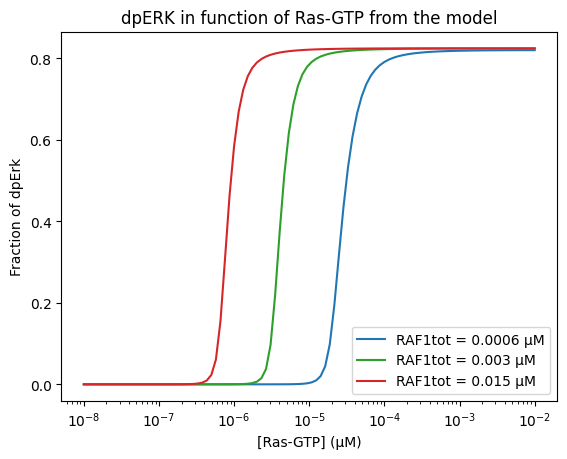

In [44]:
plt.plot(interval_values, dperktot_values_raf_load[0] ,'tab:blue', label = "RAF1tot = {} µM".format(raf1interval[0]))
plt.plot(interval_values, dperktot_values_raf_load[1],"tab:green", label = "RAF1tot = {} µM".format(raf1interval[1]))
plt.plot(interval_values, dperktot_values_raf_load[2],  "tab:red", label = "RAF1tot = {} µM".format(raf1interval[2]))
plt.xlabel("[Ras-GTP] (µM)")
plt.ylabel("Fraction of dpErk")
plt.xscale('log')
plt.legend()
plt.title("dpERK in function of Ras-GTP from the model")

In [46]:
nHlist_raf1 = []
Kmlist_raf1 = []
for i in dperktot_values_raf_load:
    coef, _ = curve_fit(Hill, interval_values, i, maxfev = 100000)
    nHlist_raf1.append(coef[0])
    Kmlist_raf1.append(coef[1])

In [47]:
nHlist_raf1

[3.988586129882929, 5.051837781081975, 5.244967057800085]

### Looping over RAF1

In [48]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [363]:
dperk_values_raf1_loop = []
for i in raf1intervallog:
    dperk_values = []
    params_rate[1] = i
    initial_values[0] = i
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_raf1_loop.append(dperk_values)

In [49]:
np.savetxt('dperk_values_raf1_loop.txt', dperk_values_raf1_loop)

NameError: name 'dperk_values_raf1_loop' is not defined

In [50]:
dperk_values_raf1_loop_load = np.loadtxt('dperk_values_raf1_loop.txt')

In [51]:
dperktot_values_raf1_loop = []
for lst in dperk_values_raf1_loop_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_raf1_loop.append(new_list)

In [52]:
nHlist_raf1_loop = []
Kmlist_raf1_loop = []

for i in dperktot_values_raf1_loop:
    coef, _ = curve_fit(Hill, interval_values, i, maxfev = 100000)
    nHlist_raf1_loop.append(coef[0])
    Kmlist_raf1_loop.append(coef[1])
    
Kmraslist_raf1_loop = Km_ifo_rastot(Kmlist_raf1_loop)

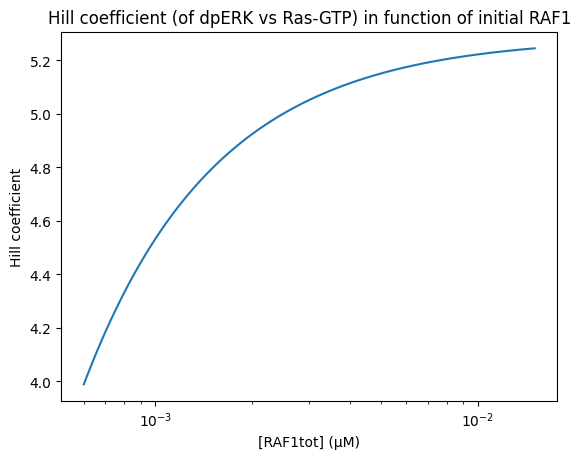

In [53]:
plt.plot(raf1intervallog, nHlist_raf1_loop)
plt.xlabel("[RAF1tot] (µM)")
plt.ylabel("Hill coefficient")
plt.title("Hill coefficient (of dpERK vs Ras-GTP) in function of initial RAF1")
plt.xscale("log")

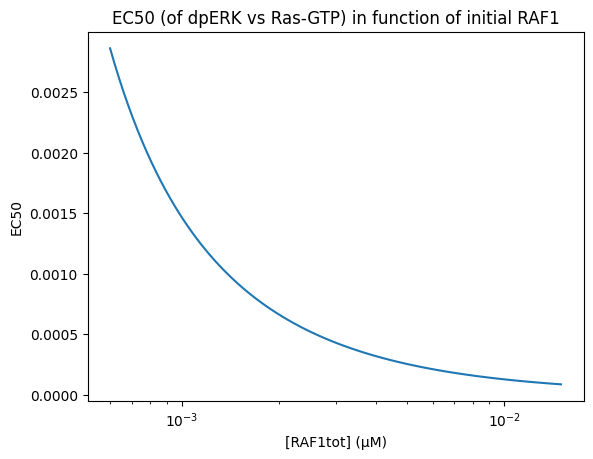

In [54]:
plt.plot(raf1intervallog, Kmraslist_raf1_loop)
plt.xlabel("[RAF1tot] (µM)")
plt.ylabel("EC50")
plt.title("EC50 (of dpERK vs Ras-GTP) in function of initial RAF1")
plt.xscale("log")

## Changing MEK

In [55]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [53]:
dperk_values_mek = []
for i in mekinterval:
    initial_values[4] = i
    params_rate[3] = i
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_mek.append(dperk_values)

In [371]:
np.savetxt('dperk_values_mek.txt', dperk_values_mek)

In [56]:
dperk_values_mek_load = np.loadtxt('dperk_values_mek.txt')

In [57]:
dperktot_values_mek = []
for lst in dperk_values_mek_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_mek.append(new_list)

Text(0.5, 1.0, 'dpERK in function of Ras-GTP from the model')

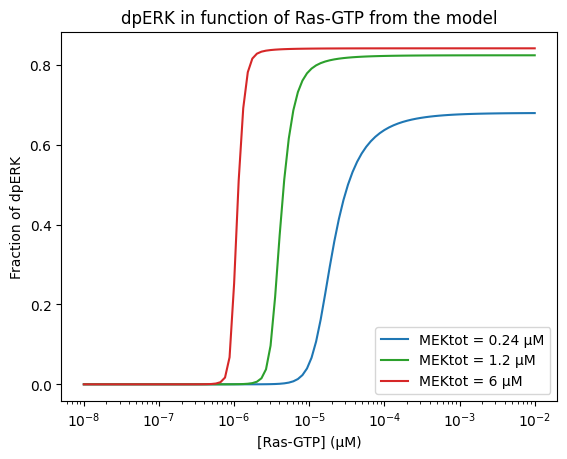

In [58]:
plt.plot(interval_values, dperktot_values_mek[0] ,'tab:blue', label = "MEKtot = {} µM".format(mekinterval[0]))
plt.plot(interval_values, dperktot_values_mek[1],"tab:green", label = "MEKtot = {} µM".format(mekinterval[1]))
plt.plot(interval_values, dperktot_values_mek[2],  "tab:red", label = "MEKtot = {} µM".format(mekinterval[2]))
plt.xlabel("[Ras-GTP] (µM)")
plt.ylabel("Fraction of dpERK")
plt.xscale('log')
plt.legend()
plt.title("dpERK in function of Ras-GTP from the model")

In [59]:
nHlist_mek = []
Kmlist_mek = []
for i in dperktot_values_mek:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_mek.append(coef[0])
    Kmlist_mek.append(coef[1])

In [60]:
nHlist_mek

[2.60905768008099, 5.051837781081975, 8.982342727061377]

### Looping over MEK

In [61]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [62]:
dperk_values_mek_loop = []
for i in mekintervallog:
    dperk_values = []
    params_rate[3] = i
    initial_values[4] = i
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_mek_loop.append(dperk_values)

KeyboardInterrupt: 

In [375]:
np.savetxt('dperk_values_mek_loop.txt', dperk_values_mek_loop)

In [63]:
dperk_values_mek_loop_load = np.loadtxt('dperk_values_mek_loop.txt')

In [64]:
dperktot_values_mek_loop = []
for lst in dperk_values_mek_loop_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_mek_loop.append(new_list)

In [65]:
nHlist_mek_loop = []
Kmlist_mek_loop = []

for i in dperktot_values_mek_loop:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_mek_loop.append(coef[0])
    Kmlist_mek_loop.append(coef[1])
    
Kmraslist_mek_loop = Km_ifo_rastot(Kmlist_mek_loop)

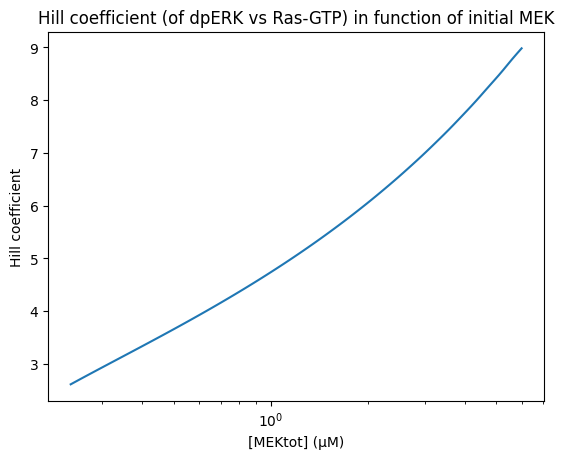

In [66]:
plt.plot(mekintervallog, nHlist_mek_loop)
plt.xlabel("[MEKtot] (µM)")
plt.ylabel("Hill coefficient")
plt.title("Hill coefficient (of dpERK vs Ras-GTP) in function of initial MEK")
plt.xscale("log")

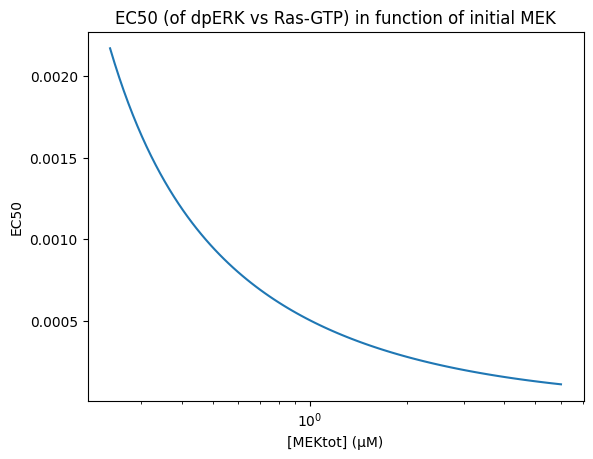

In [67]:
plt.plot(mekintervallog, Kmraslist_mek_loop)
plt.xlabel("[MEKtot] (µM)")
plt.ylabel("EC50")
plt.title("EC50 (of dpERK vs Ras-GTP) in function of initial MEK")
plt.xscale("log")

## Changing ERK

In [68]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [65]:
dperk_values_erk = []
for i in erkinterval:
    initial_values[9] = i
    params_rate[5] = i
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperktotv = Erk_ifo_erktot(dperk_values)  #division by erktot here, because it changes
    dperk_values_erk.append(dperktotv)

In [377]:
np.savetxt('dperk_values_erk.txt', dperk_values_erk)

In [69]:
dperk_values_erk_load = np.loadtxt('dperk_values_erk.txt')

Text(0.5, 1.0, 'dpERK in function of Ras-GTP from the model')

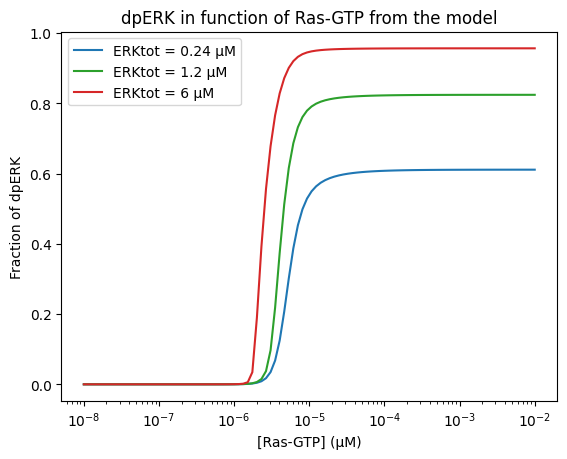

In [70]:
plt.plot(interval_values, dperk_values_erk_load[0] ,'tab:blue', label = "ERKtot = {} µM".format(erkinterval[0]))
plt.plot(interval_values, dperk_values_erk_load[1],"tab:green", label = "ERKtot = {} µM".format(erkinterval[1]))
plt.plot(interval_values, dperk_values_erk_load[2],  "tab:red", label = "ERKtot = {} µM".format(erkinterval[2]))
plt.xlabel("[Ras-GTP] (µM)")
plt.ylabel("Fraction of dpERK")
plt.xscale('log')
plt.legend()
plt.title("dpERK in function of Ras-GTP from the model")

In [71]:
nHlist_erk = []
Kmlist_erk = []
for i in dperk_values_erk_load:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_erk.append(coef[0])
    Kmlist_erk.append(coef[1])


In [72]:
nHlist_erk

[4.090847218224198, 5.051837781081975, 5.278652610195671]

### Looping over ERK

In [73]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [70]:
dperk_values_erk_loop = []
for i in erkintervallog:
    dperk_values = []
    params_rate[5] = i
    initial_values[9] = i
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperktot_v_loop = Erk_ifo_erktot(dperk_values)
    dperk_values_erk_loop.append(dperktot_v_loop)

In [382]:
np.savetxt('dperk_values_erk_loop.txt', dperk_values_erk_loop)

In [74]:
dperk_values_erk_loop_load = np.loadtxt('dperk_values_erk_loop.txt')

In [75]:
nHlist_erk_loop = []
Kmlist_erk_loop = []

for i in dperk_values_erk_loop_load:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_erk_loop.append(coef[0])
    Kmlist_erk_loop.append(coef[1])
    
Kmraslist_erk_loop = Km_ifo_rastot(Kmlist_erk_loop)

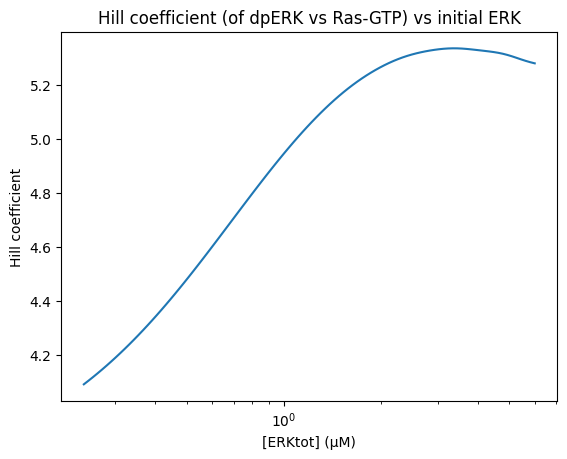

In [76]:
plt.plot(erkintervallog, nHlist_erk_loop)
plt.xlabel("[ERKtot] (µM)")
plt.ylabel("Hill coefficient")
plt.title("Hill coefficient (of dpERK vs Ras-GTP) vs initial ERK")
plt.xscale("log")

Text(0.5, 1.0, 'EC50 (of dpERK vs Ras-GTP) vs initial ERK')

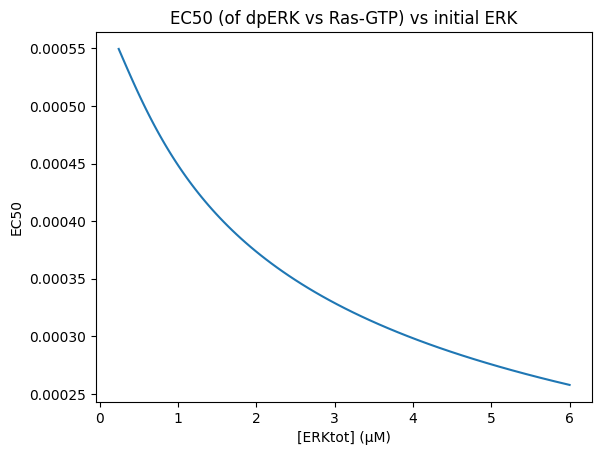

In [77]:
plt.plot(erkintervallog, Kmraslist_erk_loop)
plt.xlabel("[ERKtot] (µM)")
plt.ylabel("EC50")
plt.title("EC50 (of dpERK vs Ras-GTP) vs initial ERK")
#plt.xscale("log")

## Changing E2

In [78]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [75]:
dperk_values_e2 = []
for i in e2interval:
    params_rate[2] = i
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_e2.append(dperk_values)

In [387]:
np.savetxt('dperk_values_e2.txt', dperk_values_e2)

In [79]:
dperk_values_e2_load = np.loadtxt('dperk_values_e2.txt')

In [80]:
dperktot_values_e2 = []
for lst in dperk_values_e2_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_e2.append(new_list)

Text(0.5, 1.0, 'dpERK in function of Ras-GTP from the model')

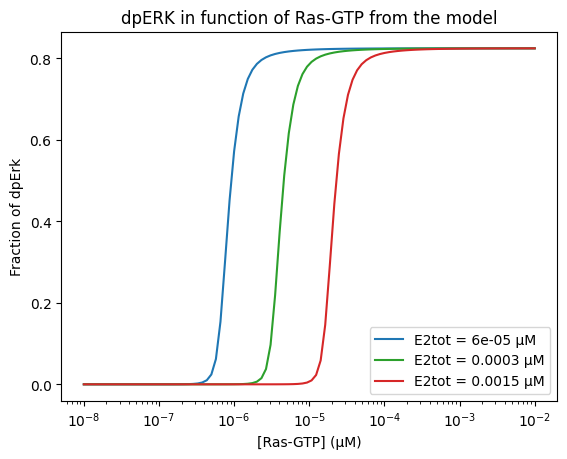

In [81]:
plt.plot(interval_values, dperktot_values_e2[0] ,'tab:blue', label = "E2tot = {} µM".format(e2interval[0]))
plt.plot(interval_values, dperktot_values_e2[1],"tab:green", label = "E2tot = {} µM".format(e2interval[1]))
plt.plot(interval_values, dperktot_values_e2[2],  "tab:red", label = "E2tot = {} µM".format(e2interval[2]))
plt.xlabel("[Ras-GTP] (µM)")
plt.ylabel("Fraction of dpErk")
plt.xscale('log')
plt.legend()
plt.title("dpERK in function of Ras-GTP from the model")

In [83]:
nHlist_e2 = []
Kmlist_e2 = []
for i in dperktot_values_e2:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_e2.append(coef[0])
    Kmlist_e2.append(coef[1])

In [84]:
nHlist_e2

[5.043550032629313, 5.051837781081975, 5.074104654728447]

### Looping over E2

In [85]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [81]:
dperk_values_e2_loop = []
for i in e2intervallog:
    dperk_values = []
    params_rate[2] = i
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_e2_loop.append(dperk_values)

In [390]:
np.savetxt('dperk_values_e2_loop.txt', dperk_values_e2_loop)

In [86]:
dperk_values_e2_loop_load = np.loadtxt('dperk_values_e2_loop.txt')

In [87]:
dperktot_values_e2_loop = []
for lst in dperk_values_e2_loop_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_e2_loop.append(new_list)

In [88]:
nHlist_e2_loop = []
Kmlist_e2_loop = []

for i in dperktot_values_e2_loop:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_e2_loop.append(coef[0])
    Kmlist_e2_loop.append(coef[1])

Kmraslist_e2_loop = Km_ifo_rastot(Kmlist_e2_loop)

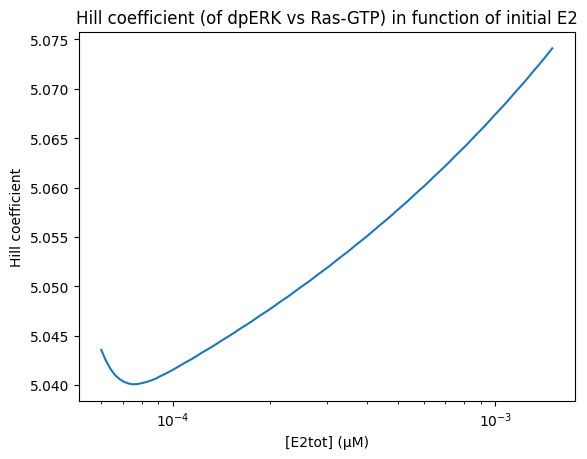

In [89]:
plt.plot(e2intervallog, nHlist_e2_loop)
plt.xlabel("[E2tot] (µM)")
plt.ylabel("Hill coefficient")
plt.title("Hill coefficient (of dpERK vs Ras-GTP) in function of initial E2")
plt.xscale("log")

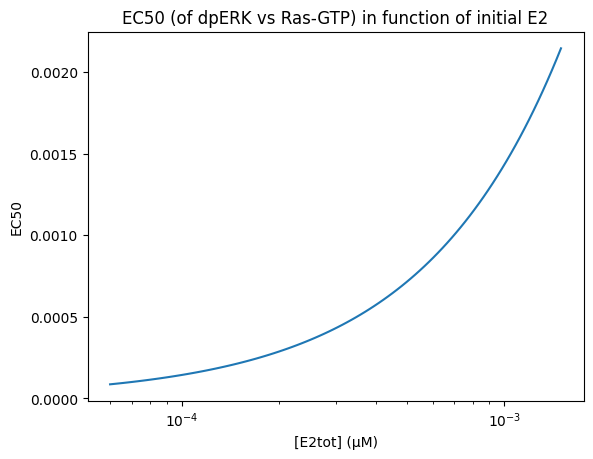

In [90]:
plt.plot(e2intervallog, Kmraslist_e2_loop)
plt.xlabel("[E2tot] (µM)")
plt.ylabel("EC50")
plt.title("EC50 (of dpERK vs Ras-GTP) in function of initial E2")
plt.xscale("log")

## Changing MEK-P'ase

In [91]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [87]:
dperk_values_mekpase = []
for i in mekpaseinterval:
    params_rate[4] = i
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_mekpase.append(dperk_values)

In [395]:
np.savetxt('dperk_values_mekpase.txt', dperk_values_mekpase)

In [92]:
dperk_values_mekpase_load = np.loadtxt('dperk_values_mekpase.txt')

In [93]:
dperktot_values_mekpase = []
for lst in dperk_values_mekpase_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_mekpase.append(new_list)

Text(0.5, 1.0, 'dpERK in function of Ras-GTP from the model')

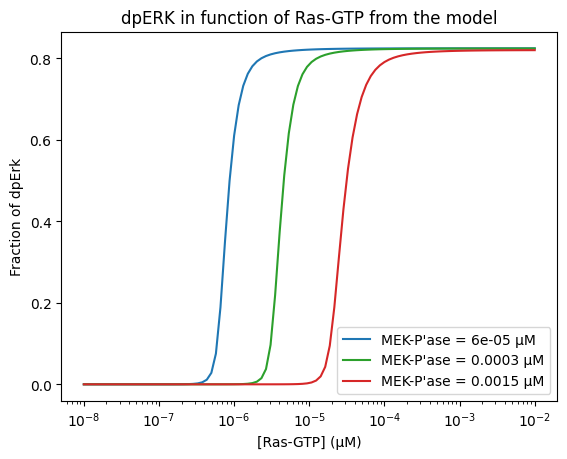

In [94]:
plt.plot(interval_values, dperktot_values_mekpase[0] ,'tab:blue', label = "MEK-P'ase = {} µM".format(mekpaseinterval[0]))
plt.plot(interval_values, dperktot_values_mekpase[1],"tab:green", label = "MEK-P'ase = {} µM".format(mekpaseinterval[1]))
plt.plot(interval_values, dperktot_values_mekpase[2],  "tab:red", label = "MEK-P'ase = {} µM".format(mekpaseinterval[2]))
plt.xlabel("[Ras-GTP] (µM)")
plt.ylabel("Fraction of dpErk")
plt.xscale('log')
plt.legend()
plt.title("dpERK in function of Ras-GTP from the model")

In [96]:
nHlist_mekpase = []
Kmlist_mekpase = []
for i in dperktot_values_mekpase:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_mekpase.append(coef[0])
    Kmlist_mekpase.append(coef[1])

In [97]:
nHlist_mekpase

[5.266748619633396, 5.051837781081975, 3.9929983621780276]

### Looping over MekPase

In [98]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [93]:
dperk_values_mekpase_loop = []
for i in mekpaseintervallog:
    dperk_values = []
    params_rate[4] = i
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_mekpase_loop.append(dperk_values)

In [399]:
np.savetxt('dperk_values_mekpase_loop.txt', dperk_values_mekpase_loop)

In [99]:
dperk_values_mekpase_loop_load = np.loadtxt('dperk_values_mekpase_loop.txt')

In [100]:
dperktot_values_mekpase_loop = []
for lst in dperk_values_mekpase_loop_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_mekpase_loop.append(new_list)

In [102]:
nHlist_mekpase_loop = []
Kmlist_mekpase_loop = []

for i in dperktot_values_mekpase_loop:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_mekpase_loop.append(coef[0])
    Kmlist_mekpase_loop.append(coef[1])
    
Kmraslist_mekpase_loop = Km_ifo_rastot(Kmlist_mekpase_loop)

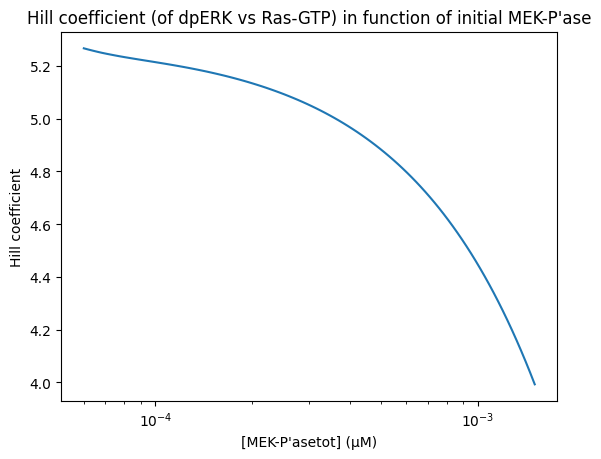

In [103]:
plt.plot(mekpaseintervallog, nHlist_mekpase_loop)
plt.xlabel("[MEK-P'asetot] (µM)")
plt.ylabel("Hill coefficient")
plt.title("Hill coefficient (of dpERK vs Ras-GTP) in function of initial MEK-P'ase")
plt.xscale("log")

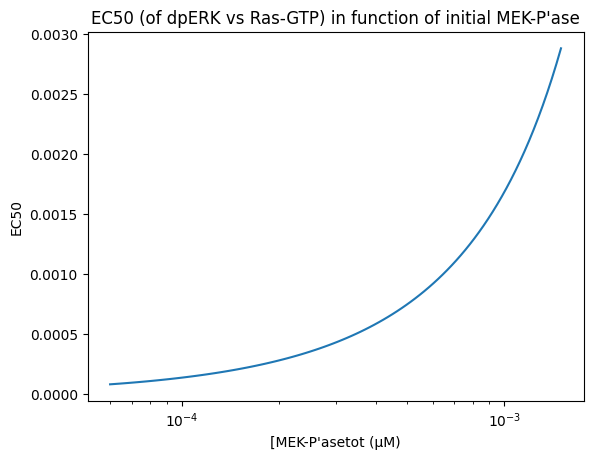

In [104]:
plt.plot(mekpaseintervallog, Kmraslist_mekpase_loop)
plt.xlabel("[MEK-P'asetot (µM)")
plt.ylabel("EC50")
plt.title("EC50 (of dpERK vs Ras-GTP) in function of initial MEK-P'ase")
plt.xscale("log")

## Changing ERK-P'ase

In [105]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [99]:
dperk_values_erkpase = []
for i in erkpaseinterval:
    params_rate[6] = i
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_erkpase.append(dperk_values)

In [405]:
np.savetxt('dperk_values_erkpase.txt', dperk_values_erkpase)

In [106]:
dperk_values_erkpase_load = np.loadtxt('dperk_values_erkpase.txt')

In [107]:
dperktot_values_erkpase = []
for lst in dperk_values_erkpase_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_erkpase.append(new_list)

Text(0.5, 1.0, 'dpERK in function of Ras-GTP from the model')

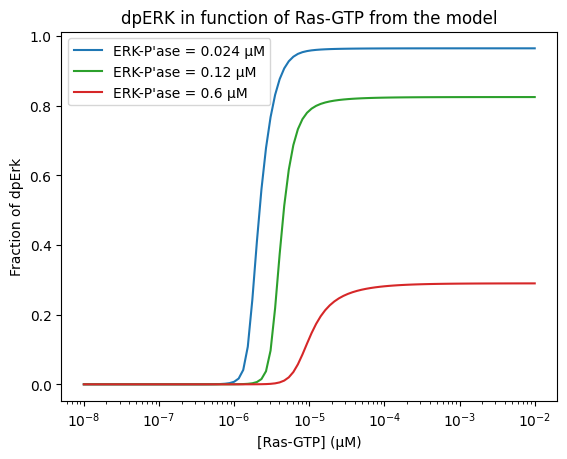

In [108]:
plt.plot(interval_values, dperktot_values_erkpase[0] ,'tab:blue', label = "ERK-P'ase = {} µM".format(erkpaseinterval[0]))
plt.plot(interval_values, dperktot_values_erkpase[1],"tab:green", label = "ERK-P'ase = {} µM".format(erkpaseinterval[1]))
plt.plot(interval_values, dperktot_values_erkpase[2],  "tab:red", label = "ERK-P'ase = {} µM".format(erkpaseinterval[2]))
plt.xlabel("[Ras-GTP] (µM)")
plt.ylabel("Fraction of dpErk")
plt.xscale('log')
plt.legend()
plt.title("dpERK in function of Ras-GTP from the model")

In [110]:
nHlist_erkpase = []
Kmlist_erkpase = []
for i in dperktot_values_erkpase:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_erkpase.append(coef[0])
    Kmlist_erkpase.append(coef[1])

In [111]:
nHlist_erkpase

[4.638696482015204, 5.051837781081975, 2.776819359964148]

### Looping over ErkPase

In [112]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [105]:
dperk_values_erkpase_loop = []
for i in erkpaseintervallog:
    dperk_values = []
    params_rate[6] = i
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_erkpase_loop.append(dperk_values)
    


In [408]:
np.savetxt('dperk_values_erkpase_loop.txt', dperk_values_erkpase_loop)

In [113]:
dperk_values_erkpase_loop_load = np.loadtxt('dperk_values_erkpase_loop.txt')

In [114]:
dperktot_values_erkpase_loop = []
for lst in dperk_values_erkpase_loop_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_erkpase_loop.append(new_list)

In [115]:
nHlist_erkpase_loop = []
Kmlist_erkpase_loop = []

for i in dperktot_values_erkpase_loop:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_erkpase_loop.append(coef[0])
    Kmlist_erkpase_loop.append(coef[1])
    
Kmraslist_erkpase_loop = Km_ifo_rastot(Kmlist_erkpase_loop)

Text(0.5, 1.0, "Hill coefficient (of dpERK vs Ras-GTP) in function of initial ERK-P'ase")

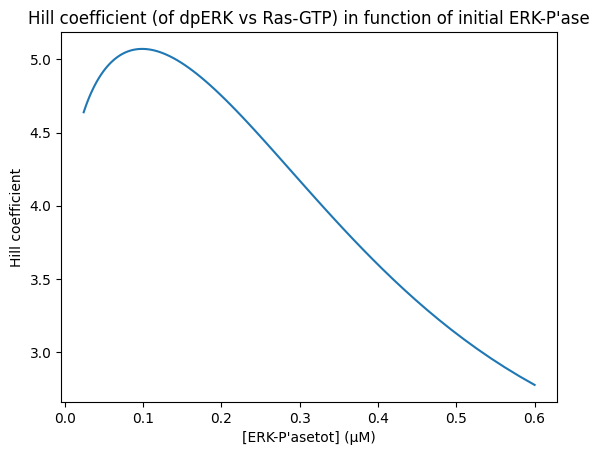

In [116]:
plt.plot(erkpaseintervallog, nHlist_erkpase_loop)
plt.xlabel("[ERK-P'asetot] (µM)")
plt.ylabel("Hill coefficient")
plt.title("Hill coefficient (of dpERK vs Ras-GTP) in function of initial ERK-P'ase")


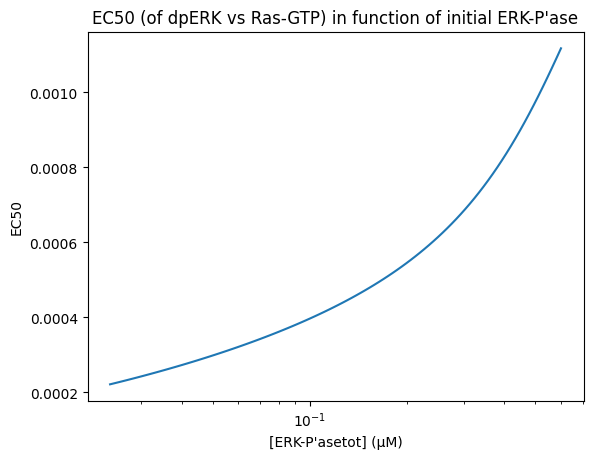

In [117]:
plt.plot(erkpaseintervallog, Kmraslist_erkpase_loop)
plt.xlabel("[ERK-P'asetot] (µM)")
plt.ylabel("EC50")
plt.title("EC50 (of dpERK vs Ras-GTP) in function of initial ERK-P'ase")
plt.xscale("log")

## Changing rate parameters

Assume that d = k, we let will fix k ($200 s^-1$), source: https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=0&id=110572

Vary Km from 60 nM - 1500 nM (Huang & Ferrell), and so we can calculate a

$a = \frac{2k}{Km}$

In [118]:
Kminterval = [0.06, 0.3, 1.5]
Kmintervallog = np.logspace(np.log(0.06) / np.log(10) , np.log(1.5)/np.log(10), num = 100)

In [119]:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [112]:
dperk_values_Km = []
for i in Kminterval:
    k = 200
    d = k
    a = 2 * k / i
    params_rate[7] = a
    params_rate[8] = d
    params_rate[9] = k
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_Km.append(dperk_values)

In [411]:
np.savetxt('dperk_values_Km.txt', dperk_values_Km)

In [120]:
dperk_values_Km_load = np.loadtxt('dperk_values_Km.txt')

In [121]:
dperktot_values_Km = []
for lst in dperk_values_Km_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_Km.append(new_list)

Text(0.5, 1.0, 'dpERK in function of Ras-GTP from the model')

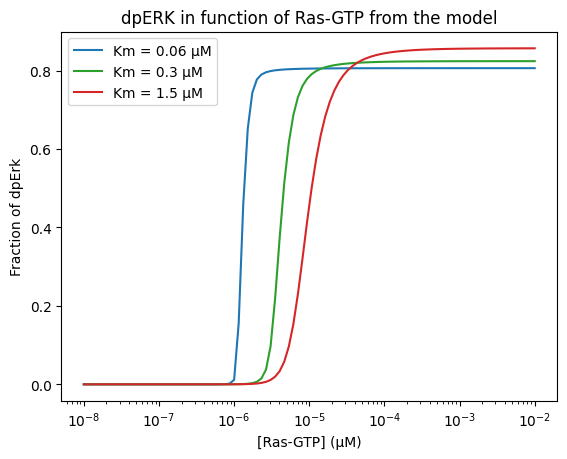

In [122]:
plt.plot(interval_values, dperktot_values_Km[0] ,'tab:blue', label = "Km = {} µM".format(Kminterval[0]))
plt.plot(interval_values, dperktot_values_Km[1],"tab:green", label = "Km = {} µM".format(Kminterval[1]))
plt.plot(interval_values, dperktot_values_Km[2],  "tab:red", label = "Km = {} µM".format(Kminterval[2]))
plt.xlabel("[Ras-GTP] (µM)")
plt.ylabel("Fraction of dpErk")
plt.xscale('log')
plt.legend()
plt.title("dpERK in function of Ras-GTP from the model")

In [124]:
nHlist_Km = []
Kmlist_Km = []
for i in dperktot_values_Km:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_Km.append(coef[0])
    Kmlist_Km.append(coef[1])

In [125]:
nHlist_Km

[10.643043856779153, 5.051837829731754, 2.9514858685392946]

### Looping over rate parameters

In [126]:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [118]:
dperk_values_Km_loop = []
for i in Kmintervallog:
    k = 200
    d = k
    a = 2 * k / i
    params_rate[7] = a
    params_rate[8] = d
    params_rate[9] = k
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_Km_loop.append(dperk_values)

In [414]:
np.savetxt('dperk_values_Km_loop.txt', dperk_values_Km_loop)

In [127]:
dperk_values_Km_loop_load = np.loadtxt('dperk_values_Km_loop.txt')

In [128]:
dperktot_values_Km_loop = []
for lst in dperk_values_Km_loop_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_Km_loop.append(new_list)

In [130]:
nHlist_Km_loop = []
Kmlist_Km_loop = []

for i in dperktot_values_Km_loop:
    coef, _ = curve_fit(Hill, interval_values, i, maxfev = 100000)
    nHlist_Km_loop.append(coef[0])
    Kmlist_Km_loop.append(coef[1])
    
Kmraslist_Km_loop = Km_ifo_rastot(Kmlist_Km_loop)

Text(0.5, 1.0, 'Hill coefficient (of dpERK vs Ras-GTP) in function of Km')

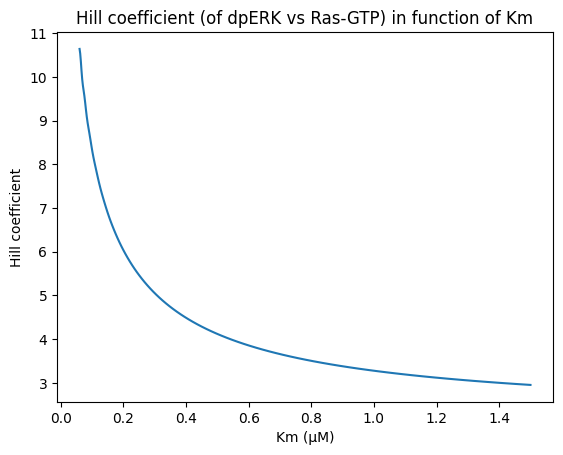

In [131]:
plt.plot(Kmintervallog, nHlist_Km_loop)
plt.xlabel("Km (µM)")
plt.ylabel("Hill coefficient")
plt.title("Hill coefficient (of dpERK vs Ras-GTP) in function of Km")
#plt.xscale("log")

Text(0.5, 1.0, 'EC50 (of dpERK vs Ras-GTP) in function of Km')

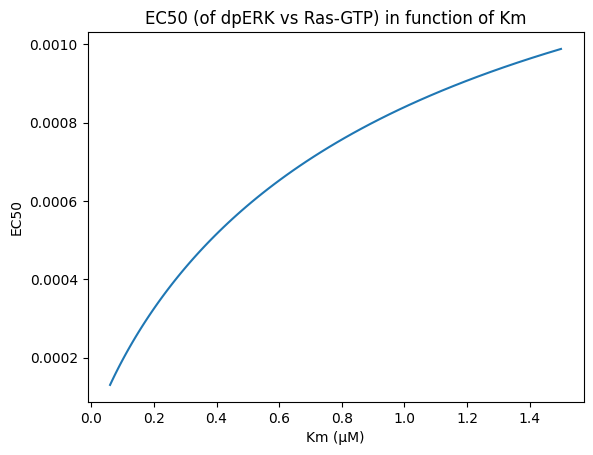

In [132]:
plt.plot(Kmintervallog, Kmraslist_Km_loop)
plt.xlabel("Km (µM)")
plt.ylabel("EC50")
plt.title("EC50 (of dpERK vs Ras-GTP) in function of Km")
#plt.xscale("log")

## Summary plots & tables

### Calculating Hill Coefficient with the formula

$nH = \frac{\log_{10}(81)}{\log_{10}(\frac{EC90}{EC10})}$

In [134]:
def round_list(list):
    new_list = []
    for i in list:
        element = round(i, 2)
        new_list.append(element)
    return new_list

def closest_value(input_list, input_value):
    arr = np.asarray(input_list)
    i = (np.abs(arr - input_value)).argmin()
    return arr[i]

def calc_EC90(dperklist, raslist = interval_values):
    maxvalue = dperklist[-1]
    value_90 = round(maxvalue * 0.9, 2)
    closest = closest_value(dperklist, value_90)
    idx = dperklist.index(closest)
    return raslist[idx]
    

    
def calc_EC10(dperklist, raslist = interval_values):
    maxvalue = dperklist[-1]
    value_10 = round(maxvalue * 0.1, 2)
    closest = closest_value(dperklist, value_10)
    idx = dperklist.index(closest)
    return raslist[idx]

def calc_nH(dperklist):
    EC90 = calc_EC90(dperklist, interval_values)
    EC10 = calc_EC10(dperklist, interval_values)
    nH = (np.log(81))/(np.log(EC90/EC10))
    return nH

In [148]:
dperktot_values_raf_load_list = dperktot_values_raf_load.tolist()
dperk_values_erk_load_list = dperk_values_erk_load.tolist()

In [151]:
print("Using the definition of nH:")
print("The interval in which nH varies when raf1 varies is {} - {}".format(round(calc_nH(dperktot_values_raf_load_list[0]), 1), round(calc_nH(dperktot_values_raf_load_list[2]), 1)))
print("The interval in which nH varies when mek varies is {} - {}".format(round(calc_nH(dperktot_values_mek[0]), 1), round(calc_nH(dperktot_values_mek[2]), 1)))
print("The interval in which nH varies when erk varies is {} - {}".format(round(calc_nH(dperk_values_erk_load_list[0]), 1), round(calc_nH(dperk_values_erk_load_list[2]), 1)))
print("The interval in which nH varies when e2 varies is {} - {}".format(round(calc_nH(dperktot_values_e2[0]), 1), round(calc_nH(dperktot_values_e2[2]), 1)))
print("The interval in which nH varies when mekpase varies is {} - {}".format(round(calc_nH(dperktot_values_mekpase[0]), 1), round(calc_nH(dperktot_values_mekpase[2]), 1)))
print("The interval in which nH varies when erkpase varies is {} - {}".format(round(calc_nH(dperktot_values_erkpase[0]), 1), round(calc_nH(dperktot_values_erkpase[2]), 1)))

Using the definition of nH:
The interval in which nH varies when raf1 varies is 3.9 - 4.5
The interval in which nH varies when mek varies is 2.4 - 7.9
The interval in which nH varies when erk varies is 3.9 - 4.5
The interval in which nH varies when e2 varies is 4.5 - 4.5
The interval in which nH varies when mekpase varies is 5.2 - 3.9
The interval in which nH varies when erkpase varies is 4.5 - 2.6


### Comparison with Huang & Ferrell

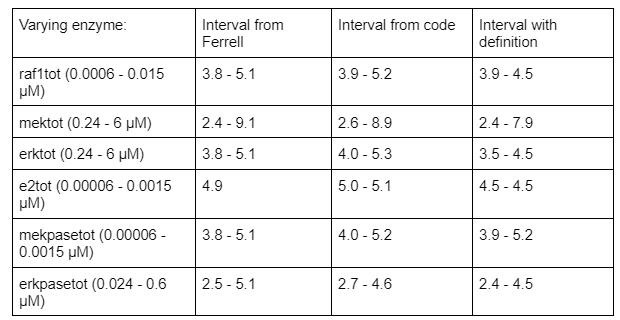

#### Hill Coefficient

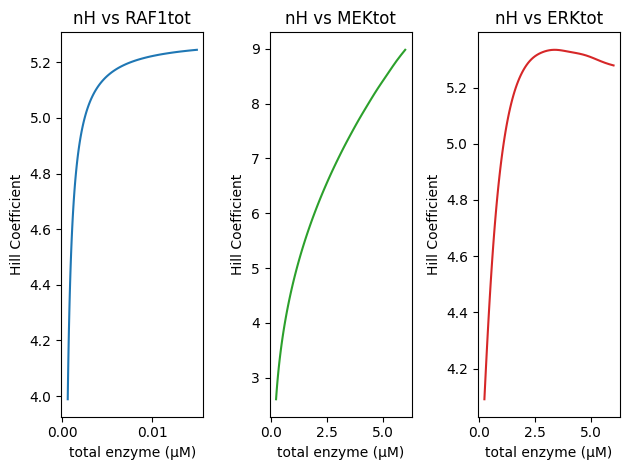

In [152]:
fig, axs = plt.subplots(1,3)
axs[0].plot(raf1intervallog, nHlist_raf1_loop, "tab:blue")
axs[0].set_title("nH vs RAF1tot")
axs[1].plot(mekintervallog, nHlist_mek_loop, "tab:green")
axs[1].set_title("nH vs MEKtot")
axs[2].plot(erkintervallog, nHlist_erk_loop, "tab:red")
axs[2].set_title("nH vs ERKtot")

for ax in axs.flat:
    ax.set(xlabel = "total enzyme (µM)", ylabel = "Hill Coefficient")

fig.tight_layout()

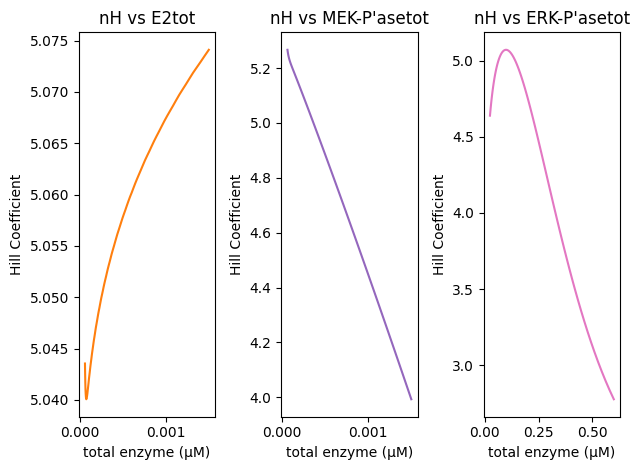

In [153]:
fig, axs = plt.subplots(1,3)
axs[0].plot(e2intervallog, nHlist_e2_loop, "tab:orange")
axs[0].set_title("nH vs E2tot")
axs[1].plot(mekpaseintervallog, nHlist_mekpase_loop, "tab:purple")
axs[1].set_title("nH vs MEK-P'asetot")
axs[2].plot(erkpaseintervallog, nHlist_erkpase_loop, "tab:pink")
axs[2].set_title("nH vs ERK-P'asetot")

for ax in axs.flat:
    ax.set(xlabel = "total enzyme (µM)", ylabel = "Hill Coefficient")

fig.tight_layout()

plt.savefig("nhvse2mekpaseerkpase.png")

#### EC50

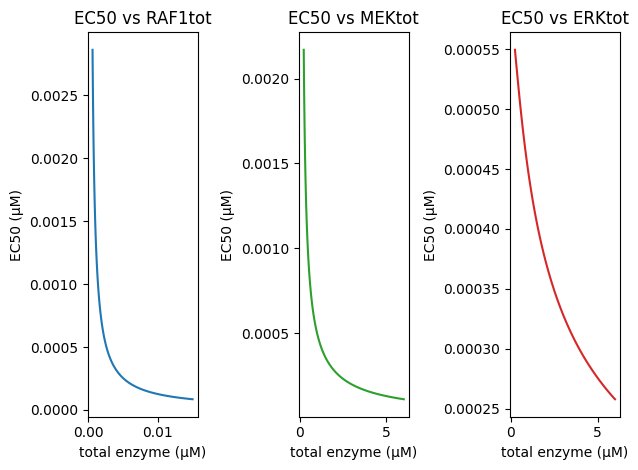

In [154]:
fig, axs = plt.subplots(1,3)
axs[0].plot(raf1intervallog, Kmraslist_raf1_loop, "tab:blue")
axs[0].set_title("EC50 vs RAF1tot")
axs[1].plot(mekintervallog, Kmraslist_mek_loop, "tab:green")
axs[1].set_title("EC50 vs MEKtot")
axs[2].plot(erkintervallog, Kmraslist_erk_loop, "tab:red")
axs[2].set_title("EC50 vs ERKtot")

for ax in axs.flat:
    ax.set(xlabel = "total enzyme (µM)", ylabel = "EC50 (µM)")

fig.tight_layout()

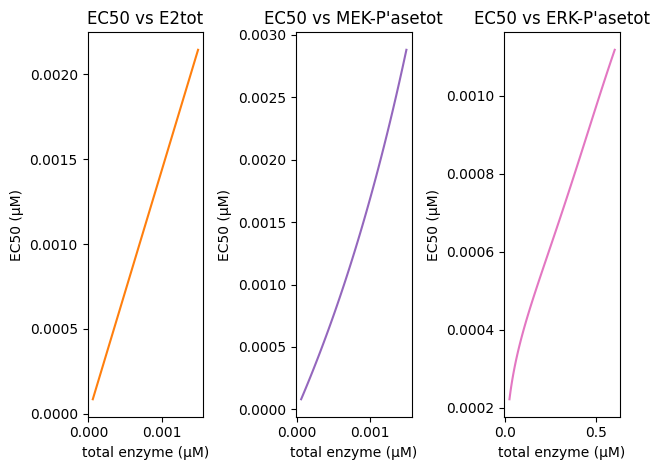

In [155]:
fig, axs = plt.subplots(1,3)
axs[0].plot(e2intervallog, Kmraslist_e2_loop, "tab:orange")
axs[0].set_title("EC50 vs E2tot")
axs[1].plot(mekpaseintervallog, Kmraslist_mekpase_loop, "tab:purple")
axs[1].set_title("EC50 vs MEK-P'asetot")
axs[2].plot(erkpaseintervallog, Kmraslist_erkpase_loop, "tab:pink")
axs[2].set_title("EC50 vs ERK-P'asetot")

for ax in axs.flat:
    ax.set(xlabel = "total enzyme (µM)", ylabel = "EC50 (µM)")

fig.tight_layout()

plt.savefig("EC50vsrafmekerk.png")

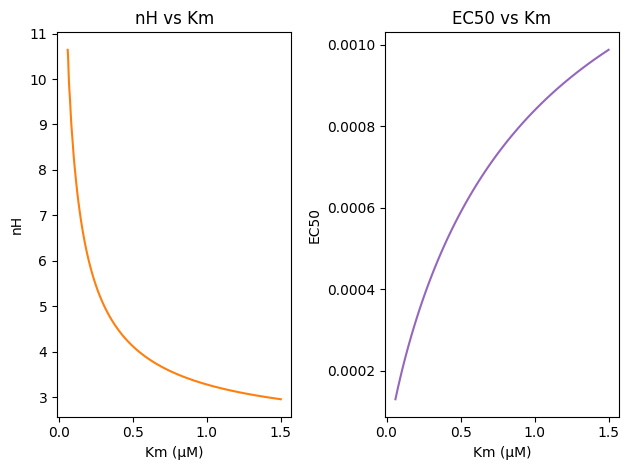

In [156]:
fig, axs = plt.subplots(1,2)
axs[0].plot(Kmintervallog, nHlist_Km_loop, "tab:orange")
axs[0].set_title("nH vs Km")
axs[0].set_ylabel("nH")
axs[1].plot(Kmintervallog, Kmraslist_Km_loop, "tab:purple")
axs[1].set_title("EC50 vs Km")
axs[1].set_ylabel("EC50")

for ax in axs.flat:
    ax.set(xlabel = "Km (µM)")

fig.tight_layout()

In [331]:
paramdict = {"raf1":0, "mek":1, "erk":2, "e2":3, "mekpase":4, "erkpase":5, "Km":6} 
xparam = [paramdict["raf1"], paramdict["mek"], paramdict["erk"], paramdict["e2"], paramdict["mekpase"], paramdict["erkpase"], paramdict["Km"]]
namesparam = ["RAF1", "MEK", "ERK", "E2", "MEK-P'ase", "ERK-P'ase", "Km"]
paramslist_nH = [nHlist_raf1, nHlist_mek, nHlist_erk, nHlist_e2, nHlist_mekpase, nHlist_erkpase, nHlist_Km]
paramslist_EC50 = [Kmlist_raf1, Kmlist_mek, Kmlist_erk, Kmlist_e2, Kmlist_mekpase, Kmlist_erkpase, Kmlist_Km]

xparam_nH = []
for i in xparam:
    xparam_nH.append(i-0.175)

xparam_EC50 = []
for i in xparam:
    xparam_EC50.append(i+0.175)

heightlist_nH = []
for i in paramslist_nH:
    heightlist_nH.append(max(i) - min(i))
    
heightlist_EC50 = []
for i in paramslist_EC50:
    heightlist_EC50.append(max(i) - min(i))
    
minlist_nH = []
for i in paramslist_nH:
    minlist_nH.append(min(i))
    
minlist_EC50 = []
for i in paramslist_EC50:
    minlist_EC50.append(min(i))

height_graph = [nHlist_raf1[-1], nHlist_mek[-1], nHlist_erk[-1], nHlist_e2[-1], nHlist_mekpase[-1], nHlist_erkpase[-1], nHlist_Km[-1]]
bottom_graph = [nHlist_raf1[0], nHlist_mek[0], nHlist_erk[0], nHlist_e2[0], nHlist_mekpase[0], nHlist_erkpase[0], nHlist_Km[0]]

heightlist_nH_norm = []
heightlist_EC50_norm = []
minlist_nH_norm = []
minlist_EC50_norm = []

for i in heightlist_nH:
    newval = i / params3[0] #params3[0] = nH of the system
    heightlist_nH_norm.append(newval)
    
for i in heightlist_EC50:
    newval = i / params3[1] #params[1] = EC50 of the system
    heightlist_EC50_norm.append(newval)

for i in minlist_nH:
    newval = i / params3[0]
    minlist_nH_norm.append(newval)
    
for i in minlist_EC50:
    newval = i / params3[1]
    minlist_EC50_norm.append(newval)

In [332]:
minlist_EC50_norm

[0.19788141395643696,
 0.2569902154265426,
 0.6006549581825343,
 0.2002151389370855,
 0.19095035922303216,
 0.5154217104440714,
 0.3040910615857409]

Text(0.5, 1.0, 'Before shifting parameters')

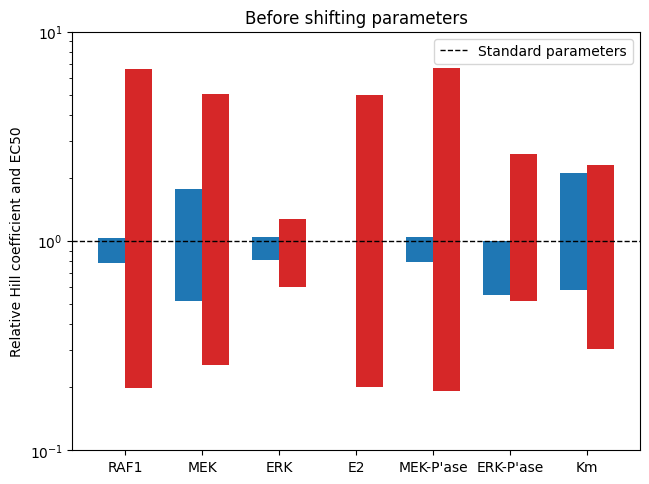

In [334]:
plt.bar(xparam_nH, heightlist_nH_norm, width = 0.35, bottom = minlist_nH_norm, color="tab:blue")
plt.bar(xparam_EC50, heightlist_EC50_norm, width = 0.35, bottom = minlist_EC50_norm, color = "tab:red")
plt.ylim([0.1, 10])
plt.yscale('log')
plt.xticks(xparam, namesparam)
plt.tight_layout()
plt.ylabel("Relative Hill coefficient and EC50")
plt.axhline(y = 1, linestyle = "--", linewidth = 1, color = "k", label = "Standard parameters")
plt.legend()
plt.title("Before shifting parameters")

# Parameter Space Exploration: Varying all parameters: Latin Hypercube Sampling

In [159]:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [133]:
N = 10000 #number of choices we can have

Km_interval_LHS_array = np.logspace(np.log(0.06) / np.log(10) , np.log(1.5)/np.log(10), num = N)
mek_interval_LHS_array = np.logspace((np.log(0.24) / np.log(10)) , np.log(6) / np.log(10), num = N)
erk_interval_LHS_array = np.logspace((np.log(0.24) / np.log(10)) , np.log(6) / np.log(10), num = N)
raf1_interval_LHS_array = np.logspace((np.log(0.0006) / np.log(10)) , np.log(0.015) / np.log(10), num = N)
e2_interval_LHS_array = np.logspace((np.log(0.00006) / np.log(10)) , np.log(0.0015) / np.log(10), num = N)
mekpase_interval_LHS_array = np.logspace((np.log(0.00006) / np.log(10)) , np.log(0.0015) / np.log(10), num = N)
erkpase_interval_LHS_array = np.logspace((np.log(0.024) / np.log(10)) , np.log(0.6) / np.log(10), num = N)

mek_interval_LHS_list = mek_interval_LHS_array.tolist()
erk_interval_LHS_list = mek_interval_LHS_array.tolist()
raf1_interval_LHS_list = raf1_interval_LHS_array.tolist()
e2_interval_LHS_list = e2_interval_LHS_array.tolist()
mekpase_interval_LHS_list = mekpase_interval_LHS_array.tolist()
erkpase_interval_LHS_list = erkpase_interval_LHS_array.tolist()
Km_interval_LHS_list = Km_interval_LHS_array.tolist()

In [134]:
random_samples = []

count = 0
while count < N: #make a list with 100 combinations of parameters. each value of a parameter can only be used once.
    count += 1
    #pick a random value of the interval
    mekvalue = random.choice(mek_interval_LHS_list)
    erkvalue = random.choice(erk_interval_LHS_list)
    raf1value = random.choice(raf1_interval_LHS_list)
    e2value = random.choice(e2_interval_LHS_list)
    mekpasevalue = random.choice(mekpase_interval_LHS_list)
    erkpasevalue = random.choice(erkpase_interval_LHS_list)
    kvalue = 200
    Kmvalue = random.choice(Km_interval_LHS_list)
    dvalue = kvalue  
    avalue = (2 * kvalue) / Kmvalue
    
    #delete it from the list
    mek_interval_LHS_list.remove(mekvalue)
    erk_interval_LHS_list.remove(erkvalue)
    raf1_interval_LHS_list.remove(raf1value)
    e2_interval_LHS_list.remove(e2value)
    mekpase_interval_LHS_list.remove(mekpasevalue)
    erkpase_interval_LHS_list.remove(erkpasevalue)

    Km_interval_LHS_list.remove(Kmvalue)
    
    #add values to the big list
    random_samples.append([raf1value, e2value, mekvalue, mekpasevalue, erkvalue, erkpasevalue, avalue, dvalue, kvalue, Kmvalue])

In [417]:
np.savetxt('random_samples.txt', random_samples)

In [160]:
random_samples_load = np.loadtxt('random_samples.txt')

In [135]:
NN = 1000 #how many times we want to do it

dperk_values_LHS = []
for i in range(NN):
    params_rate[1:] = random_samples_load[i][0:9]
         
    initial_values[0] = random_samples_load[i][0] #0 = raf1_0
    initial_values[4] = random_samples_load[i][2] #4 = mek_0
    initial_values[9] = random_samples_load[i][4] #9 = erk_0
        
    dperk_values = []
    for z in interval_values:
        params_rate[0] = z
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_LHS.append(dperk_values)

In [419]:
np.savetxt('dperk_values_LHS.txt', dperk_values_LHS)

In [161]:
dperk_values_LHS_load = np.loadtxt('dperk_values_LHS.txt')

In [162]:
# You can try to use this function to fit the curve, it should work also in the borderline cases 
from scipy.optimize import curve_fit

def model(x, a, b, c):
    return c*x**a/(x**a+b**a) 

# Function to fit the curve z(x)
def Hill_fit(z,x):
    yR= z/max(z) # normalize 
    popt, _ = curve_fit(model, x, yR, maxfev = 100000)
    # If you have problems with the fit it can be useful to specify 
    # the lower and upper bounds on the parameters (bo)
    # or an initial guess for the values of the parameters (p0)
    # Ex.  popt, _ = curve_fit(model, x, yR, bo= ([0,0,0],[10, 5000, 2]), pO= [5,1000, 1]) (I used random numbers in this example)
    a,b,c = popt  
    return [round(a,8), round(b,8), round(c,8)]

In [163]:
#Check if all fits are "good"
def do(i):
    a,b,c = Hill_fit(dperk_values_LHS_load[i],interval_values)
    Fit_prova = model(interval_values, a,b,c)*max(dperk_values_LHS[i]) 

    plt.plot(interval_values, dperk_values_LHS_load[i])
    plt.plot(interval_values, Fit_prova, '--', label=f'Hill coeff= {np.round(a,2)}')
    plt.legend()
    plt.xscale('log')
    plt.xlabel('Rastot')
    plt.ylabel('dpErk')
    plt.show()

In [138]:
len(dperk_values_LHS)

1000

In [164]:
nHlist_LHS = []
Kmlist_LHS = []
for i in dperk_values_LHS_load:
    coefs = Hill_fit(i, interval_values)
    nHlist_LHS.append(coefs[0])
    Kmlist_LHS.append(coefs[1])
    
nHlist_LHS_prob = []
for i in nHlist_LHS:
    nHlist_LHS_prob.append(i/100)
    
Kmlist_LHS_ras = []
for i in Kmlist_LHS:
    new_Km = i / interval_values[-1]
    Kmlist_LHS_ras.append(new_Km)

In [304]:
np.savetxt("nHlist_LHS.txt", nHlist_LHS)

In [305]:
nHlist_LHS_load = np.loadtxt("nHlist_LHS.txt")

In [169]:
Kmlist_LHS_ras2 = Km_ifo_rastot(Kmlist_LHS)

### Probabilities and histograms

In [165]:
def probability_nH(nHlist, nHexpected, percentage):
    count_a = 0 #a) nH below nHexpected - nHexpected * percentage
    count_b = 0 #b) nH between nHexpected nHexpected * percentage and nHexpected + nHexpected * percentage
    count_c = 0 #c) nHexpected + nHexpected * percentage

    upper = nHexpected + nHexpected * percentage
    lower = nHexpected - nHexpected * percentage
    for i in nHlist:
        if i < lower :
            count_a += 1
        elif lower <= i <= upper:
            count_b += 1
        else:
            count_c += 1
            
    print("The probability of a Hill Coefficient below {} is {}\nThe probability of a Hill Coefficient between {} and {} is {} \nThe probability of a Hill Coefficient above {} is {}".format(lower, count_a/len(nHlist), lower, upper, count_b/len(nHlist), upper, count_c/len(nHlist)))

In [166]:
def probability_EC50(Kmlist, Kmexpected, percentage):
    count_a = 0
    count_b = 0
    count_c = 0
    
    upper = Kmexpected + (Kmexpected * percentage)
    lower = Kmexpected - Kmexpected * percentage
    
    for i in Kmlist:
        if i < lower:
            count_a += 1
        elif lower <= i <= upper:
            count_b += 1
        else:
            count_c += 1
    
    print("The probability of an EC50 below {} is {}\nThe probability of an EC50 between {} and {} is {} \nThe probability of an EC50 above {} is {}".format(lower, count_a/len(Kmlist), lower, upper, count_b/len(Kmlist), upper, count_c/len(Kmlist)))

In [167]:
probability_nH(nHlist_LHS, 2, 0.1)

The probability of a Hill Coefficient below 1.8 is 0.059
The probability of a Hill Coefficient between 1.8 and 2.2 is 0.064 
The probability of a Hill Coefficient above 2.2 is 0.877


In [170]:
probability_EC50(Kmlist_LHS_ras2, 0.5, 0.2)

The probability of an EC50 below 0.4 is 1.0
The probability of an EC50 between 0.4 and 0.6 is 0.0 
The probability of an EC50 above 0.6 is 0.0


Text(0.5, 1.0, 'Before shifting')

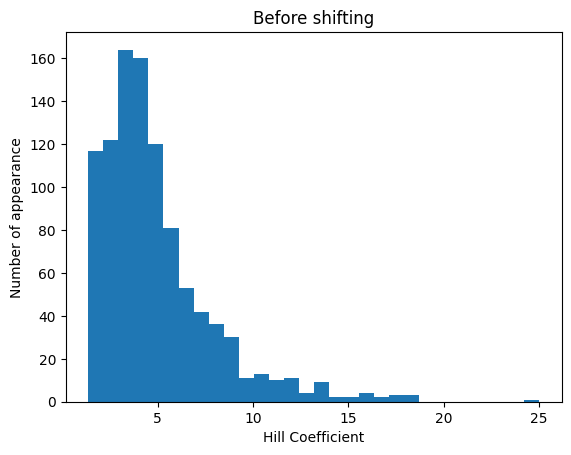

In [335]:
plt.hist(nHlist_LHS, density = False, bins = 30)
plt.ylabel("Number of appearance")
plt.xlabel("Hill Coefficient")
plt.title("Before shifting")

Text(0.5, 1.0, 'Before shifting')

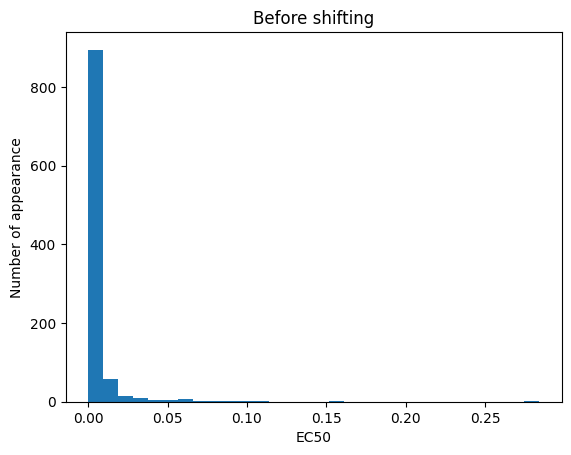

In [346]:
plt.hist(Kmlist_LHS_ras2, density = False, bins = 30)
plt.xlabel("EC50")
plt.ylabel("Number of appearance")
plt.title("Before shifting")

### Varying parameters around a point

To see whether the Hill Coefficient and EC50 much when varying a little bit around a point

In [272]:
def vary_around_one_point(inputlist): #inputlist = one random combination of parameters
    raf1, e2, mek, mekpase, erk, erkpase, a, d, k, Km = inputlist
    #determine Hill Coefficient of the inputlist
    params_rate[1:] = inputlist[:9]
    initial_values[0] = raf1
    initial_values[4] = mek
    initial_values[9] = erk
    
    dperk_values_initial = []
    for z in interval_values:
        params_rate[0] = z
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values_initial.append(solutions[:,14][-1])
        
    nH_initial, b, c = Hill_fit(dperk_values_initial, interval_values)
    
    #list with values around the initial inputlist
    around_raf1 = np.linspace(raf1 - 0.0001, raf1 + 0.0001, num = 100)
    around_mek = np.linspace(mek - 0.01, mek + 0.01, num = 100)
    around_e2 = np.linspace(e2 - 0.00001, e2 + 0.00001, num = 100)
    around_mekpase = np.linspace(mekpase - 0.00001, mekpase + 0.00001, num = 100)
    around_erk = np.linspace(erk - 0.01, erk + 0.01, num = 100)
    around_erkpase = np.linspace(erkpase - 0.001, erkpase + 0.001, num = 100)
    around_k = np.linspace(k - 10, k + 10, num = 100)
    around_Km = np.linspace(Km - 0.01, Km + 0.01, num = 100)
    
    params_rate[1:] = inputlist[:9] #reset, just to be sure
    
    big_nH_list = []
    
    #raf1
    dperk_values_around_raf1 = []
    for i in around_raf1:
        initial_values[0] = i
        params_rate[1] = i
        dperk_values = []
        for j in interval_values:
            params_rate[0] = j
            solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
            dperk_values.append(solutions[:,14][-1])
        dperk_values_around_raf1.append(dperk_values)
        
    for i in dperk_values_around_raf1:
        coefs = Hill_fit(i, interval_values)
        big_nH_list.append(coefs[0])
        
    params_rate[1:] = inputlist[:9] #reset
    initial_values[0] = inputlist[0]
    
    #e2
    dperk_values_around_e2 = []
    for i in around_e2:
        params_rate[2] = i
        dperk_values = []
        for j in interval_values:
            params_rate[0] = j
            solutions = odeint(mapkmodel, initial_values, t, args = (params_rate,))
            dperk_values.append(solutions[:,14][-1])
        dperk_values_around_e2.append(dperk_values)
    
    for i in dperk_values_around_e2:
        coefs = Hill_fit(i, interval_values)
        big_nH_list.append(coefs[0])
        
    params_rate[1:] = inputlist[:9]

        
    #mek
    dperk_values_around_mek = []
    for i in around_mek:
        initial_values[4] = i
        params_rate[3] = i
        dperk_values = []
        for j in interval_values:
            params_rate[0] = j
            solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
            dperk_values.append(solutions[:,14][-1])
        dperk_values_around_mek.append(dperk_values)
        
    for i in dperk_values_around_mek:
        coefs = Hill_fit(i, interval_values)
        big_nH_list.append(coefs[0])
    
    params_rate[1:] = inputlist[:9]
    initial_values[4] = inputlist[2]
    
    #mekpase
    dperk_values_around_mekpase = []
    for i in around_mekpase:
        params_rate[4] = i
        dperk_values = []
        for j in interval_values:
            params_rate[0] = j
            solutions = odeint(mapkmodel, initial_values, t, args = (params_rate,))
            dperk_values.append(solutions[:,14][-1])
        dperk_values_around_mekpase.append(dperk_values)
    
    for i in dperk_values_around_mekpase:
        coefs = Hill_fit(i, interval_values)
        big_nH_list.append(coefs[0])
    
    params_rate[1:] = inputlist[:9]
    
    #erk
    dperk_values_around_erk = []
    for i in around_erk:
        initial_values[9] = i
        params_rate[5] = i
        dperk_values = []
        for j in interval_values:
            params_rate[0] = j
            solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
            dperk_values.append(solutions[:,14][-1])
        dperk_values_around_erk.append(dperk_values)
        
    for i in dperk_values_around_erk:
        coefs = Hill_fit(i, interval_values)
        big_nH_list.append(coefs[0]) 
        
    params_rate[1:] = inputlist[:9]
    initial_values[9] = inputlist[4]
    
    #erkpase
    dperk_values_around_erkpase = []
    for i in around_erkpase:
        params_rate[6] = i
        dperk_values = []
        for j in interval_values:
            params_rate[0] = j
            solutions = odeint(mapkmodel, initial_values, t, args = (params_rate,))
            dperk_values.append(solutions[:,14][-1])
        dperk_values_around_erkpase.append(dperk_values)
    
    for i in dperk_values_around_erkpase:
        coefs = Hill_fit(i, interval_values)
        big_nH_list.append(coefs[0])
        
    params_rate[1:] = inputlist[:9]
    
    #k
    
    dperk_values_around_k = []
    for i in around_k:
        d_i = i
        a_i = 2*i / inputlist[9] #Km = inputlist[9]
        params_rate[7] = a_i
        params_rate[8] = d_i
        params_rate[9] = i
        dperk_values = []
        for j in interval_values:
            params_rate[0] = j
            solutions = odeint(mapkmodel, initial_values, t, args = (params_rate,))
            dperk_values.append(solutions[:,14][-1])
        dperk_values_around_k.append(dperk_values)
        
    for i in dperk_values_around_k:
        coefs = Hill_fit(i, interval_values)
        big_nH_list.append(coefs[0])
        
    params_rate[1:] = inputlist[:9]
    
    #Km
    
    dperk_values_around_Km = []
    for i in around_Km:
        a_i = 2 * inputlist[8] / i #k = inputlist[8]
        params_rate[7] = a_i
        dperk_values = []
        for j in interval_values:
            params_rate[0] = j
            solutions = odeint(mapkmodel, initial_values, t, args = (params_rate,))
            dperk_values.append(solutions[:,14][-1])
        dperk_values_around_Km.append(dperk_values)
        
    for i in dperk_values_around_Km:
        coefs = Hill_fit(i, interval_values)
        big_nH_list.append(coefs[0])
        
    return big_nH_list, nH_initial
    
    
        

In [273]:
vary_list = vary_around_one_point(random_samples[0])

In [274]:
vary_list[0][0] - vary_list[0][-1]

0.023467479999999874

In [275]:
vary_list_big = []
for i in range(0,100):
    vary_list_e = vary_around_one_point(random_samples[i])
    vary = vary_list_e[i][0] - vary_list_e[i][-1]
    vary_list_big.append(vary)

IndexError: invalid index to scalar variable.

We observe very small variations when looking in the neighbourhood of the parameters. 

## Expansion of the parameterspace: Try to find the right parameter combination

Because the probabilities of getting a Hill Coefficient of 2 and an EC50 of 0.5 is significantly low, we will try to find the range of parameter in which the probabilities are higher. 
- Lowering raf1 leads to a lower Hill Coefficient
- Lowering mek leads to a lower Hill Coefficient
- Lowering erk leads to a lower Hill Coefficient
- E2 has a slight effect on the Hill Coefficient
- Increasing mekpase leads to a lower Hill Coefficient
- Increasing erkpase leads to a lower Hill Coefficient

We look again at the values of nH when a parameter individually changes. Then we take the interval for when the Hill is around 2. We do this for each parameter and the remaining intervals are those we will use in the LHS to calculate the probabilities again. We can use a loop to find a more accurate value

In [173]:
#end = end/10 & start = start/10 for raf1, mek, erk and e2
#end = end*10 & start = start*10 for mekpase and erkpase and Km
raf1interval_new = [0.00006, 0.0003, 0.0015]
mekinterval_new = [0.024, 0.12, 0.6] 
erkinterval_new = [0.024, 0.12, 0.6]
e2interval_new = [0.000006, 0.0003, 0.00015]
mekpaseinterval_new = [0.0006, 0.003, 0.015]
erkpaseinterval_new = [0.24, 1.2, 6]
Kminterval_new = [0.6, 3, 15]

raf1intervallog_new = np.logspace((np.log(0.00006) / np.log(10)) , np.log(0.0015) / np.log(10), num = 100)
mekintervallog_new = np.logspace((np.log(0.024) / np.log(10)) , np.log(0.6) / np.log(10), num = 100)
erkintervallog_new = np.logspace((np.log(0.024) / np.log(10)) , np.log(0.6) / np.log(10), num = 10000)
e2intervallog_new = np.logspace((np.log(0.000006) / np.log(10)) , np.log(0.00015) / np.log(10), num = 10000)
mekpaseintervallog_new = np.logspace((np.log(0.0006) / np.log(10)) , np.log(0.015) / np.log(10), num = 100)
erkpaseintervallog_new = np.logspace((np.log(0.24) / np.log(10)) , np.log(6) / np.log(10), num = 100)
Kmintervallog_new = np.logspace((np.log(0.6) / np.log(10)) , np.log(15) / np.log(10), num = 100)

In [174]:
def find_new_interval(paramlist, nhlist, left = 1.5, right = 2.2):
    for i in nhlist:
        if i > left:
            nhidx_left = nhlist.index(i)
            break
        else:
            continue
    
    for i in nhlist:
        if i > right:
            nhidx_right = nhlist.index(i)
            break
        else:
            continue
        
    new_left = paramlist[nhidx_left]
    new_right = paramlist[nhidx_right]
    
    new_interval = np.logspace((np.log(new_left) / np.log(10)) , np.log(new_right) / np.log(10), num = 10000)
    
    return new_interval
        

## Shifting raf1

In [175]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [151]:
dperk_values_raf_exp = []
for i in raf1interval_new:
    initial_values[0] = i
    params_rate[1] = i
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_raf_exp.append(dperk_values)

In [424]:
np.savetxt('dperk_values_raf_exp.txt', dperk_values_raf_exp)

In [176]:
dperk_values_raf_exp_load = np.loadtxt('dperk_values_raf_exp.txt')

In [178]:
dperktot_values_raf_exp = []
for lst in dperk_values_raf_exp_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_raf_exp.append(new_list)

Text(0.5, 1.0, 'dpERK in function of Ras-GTP from the model')

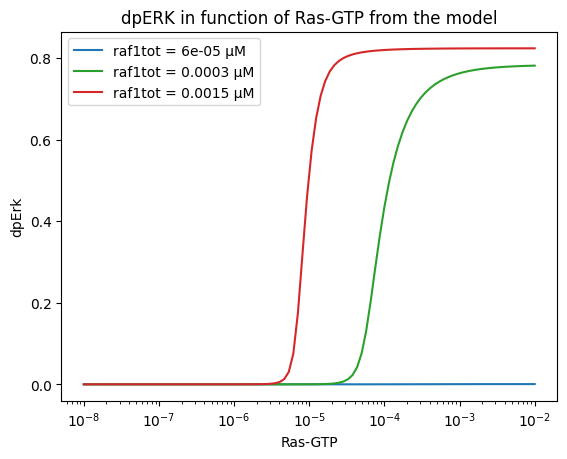

In [179]:
plt.plot(interval_values, dperktot_values_raf_exp[0] ,'tab:blue', label = "raf1tot = {} µM".format(raf1interval_new[0]))
plt.plot(interval_values, dperktot_values_raf_exp[1],"tab:green", label = "raf1tot = {} µM".format(raf1interval_new[1]))
plt.plot(interval_values, dperktot_values_raf_exp[2],  "tab:red", label = "raf1tot = {} µM".format(raf1interval_new[2]))
plt.xlabel("Ras-GTP")
plt.ylabel("dpErk")
plt.xscale('log')
plt.legend()
plt.title("dpERK in function of Ras-GTP from the model")

In [180]:
nHlist_raf1_exp = []
Kmlist_raf1_exp = []
for i in dperktot_values_raf_exp:
    coef, _ = curve_fit(Hill, interval_values, i, maxfev = 100000)
    nHlist_raf1_exp.append(coef[0])
    Kmlist_raf1_exp.append(coef[1])

In [181]:
nHlist_raf1_exp

[1.4269378422072623, 2.7062031175046233, 4.796163575000375]

In [182]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [157]:
dperk_values_raf1_loop_exp = []
for i in raf1intervallog_new:
    dperk_values = []
    params_rate[1] = i
    initial_values[0] = i
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_raf1_loop_exp.append(dperk_values)
    


In [427]:
np.savetxt('dperk_values_raf1_loop_exp.txt', dperk_values_raf1_loop_exp)

In [183]:
dperk_values_raf1_loop_exp_load = np.loadtxt('dperk_values_raf1_loop_exp.txt')

In [184]:
dperktot_values_raf1_loop_exp = []
for lst in dperk_values_raf1_loop_exp_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_raf1_loop_exp.append(new_list)

In [185]:
nHlist_raf1_loop_exp = []
Kmlist_raf1_loop_exp = []

for i in dperktot_values_raf1_loop_exp:
    coef, _ = curve_fit(Hill, interval_values, i, maxfev = 100000)
    nHlist_raf1_loop_exp.append(coef[0])
    Kmlist_raf1_loop_exp.append(coef[1])
    
Kmraslist_raf1_loop_exp = Km_ifo_rastot(Kmlist_raf1_loop_exp)

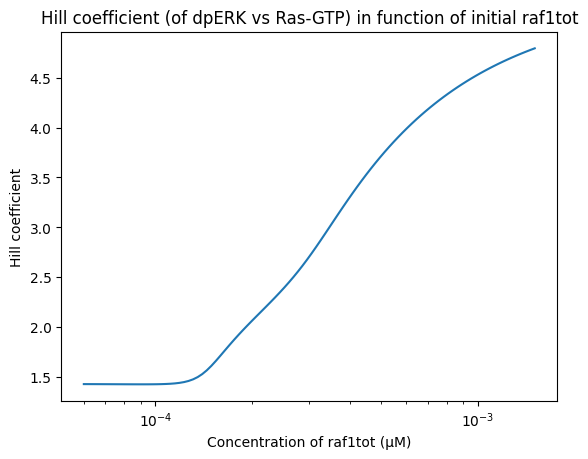

In [186]:
plt.plot(raf1intervallog_new, nHlist_raf1_loop_exp)
plt.xlabel("Concentration of raf1tot (µM)")
plt.ylabel("Hill coefficient")
plt.title("Hill coefficient (of dpERK vs Ras-GTP) in function of initial raf1tot")
plt.xscale("log")

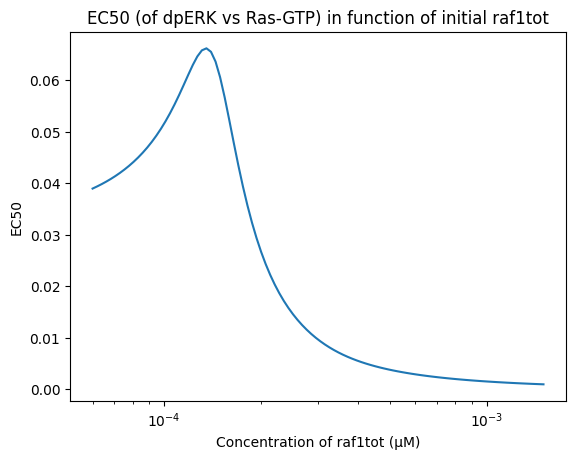

In [187]:
plt.plot(raf1intervallog_new, Kmraslist_raf1_loop_exp)
plt.xlabel("Concentration of raf1tot (µM)")
plt.ylabel("EC50")
plt.title("EC50 (of dpERK vs Ras-GTP) in function of initial raf1tot")
plt.xscale("log")

In [188]:
new_raf1_interval = find_new_interval(raf1intervallog_new, nHlist_raf1_loop_exp)

In [189]:
new_raf1_interval_list = new_raf1_interval.tolist()

## Shifting mek

In [190]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [165]:
dperk_values_mek_exp = []
for i in mekinterval_new:
    initial_values[4] = i
    params_rate[3] = i
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_mek_exp.append(dperk_values)

In [433]:
np.savetxt('dperk_values_mek_exp.txt', dperk_values_mek_exp)

In [191]:
dperk_values_mek_exp_load = np.loadtxt('dperk_values_mek_exp.txt')

In [192]:
dperktot_values_mek_exp = []
for lst in dperk_values_mek_exp_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_mek_exp.append(new_list)

Text(0.5, 1.0, 'dpERK in function of Ras-GTP from the model')

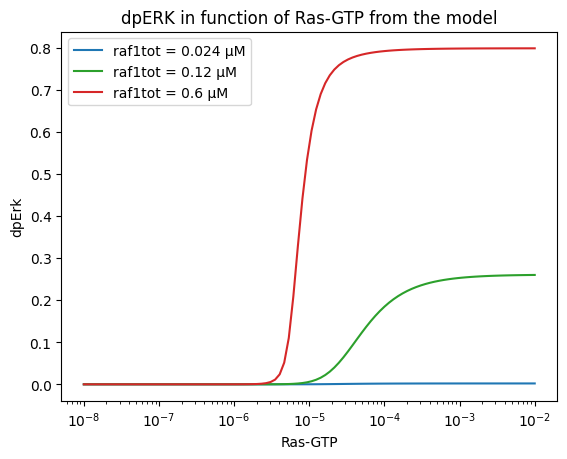

In [193]:
plt.plot(interval_values, dperktot_values_mek_exp[0] ,'tab:blue', label = "raf1tot = {} µM".format(mekinterval_new[0]))
plt.plot(interval_values, dperktot_values_mek_exp[1],"tab:green", label = "raf1tot = {} µM".format(mekinterval_new[1]))
plt.plot(interval_values, dperktot_values_mek_exp[2],  "tab:red", label = "raf1tot = {} µM".format(mekinterval_new[2]))
plt.xlabel("Ras-GTP")
plt.ylabel("dpErk")
plt.xscale('log')
plt.legend()
plt.title("dpERK in function of Ras-GTP from the model")

In [194]:
nHlist_mek_exp = []
Kmlist_mek_exp = []
for i in dperktot_values_mek_exp:
    coef, _ = curve_fit(Hill, interval_values, i, maxfev = 100000)
    nHlist_mek_exp.append(coef[0])
    Kmlist_mek_exp.append(coef[1])

In [195]:
nHlist_mek_exp

[1.7360637921457018, 1.6601539312329134, 3.9211445379297216]

In this area of the parameter space, the Hill Coefficient doesn't increase/decrease monotonous, so to be sure we will use a loop.

In [196]:
mekintervallog_new = np.logspace((np.log(0.024) / np.log(10)) , np.log(0.6) / np.log(10), num = 100)

In [197]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [172]:
dperk_values_mek_loop_exp = []
for i in mekintervallog_new:
    dperk_values = []
    params_rate[3] = i
    initial_values[4] = i
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_mek_loop_exp.append(dperk_values)

In [436]:
np.savetxt('dperk_values_mek_loop_exp.txt', dperk_values_mek_loop_exp)

In [198]:
dperk_values_mek_loop_exp_load = np.loadtxt('dperk_values_mek_loop_exp.txt')

In [199]:
dperktot_values_mek_loop_exp = []
for lst in dperk_values_mek_loop_exp_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_mek_loop_exp.append(new_list)

In [200]:
nHlist_mek_loop_new = []
Kmlist_mek_loop_new = []

for i in dperktot_values_mek_loop_exp:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_mek_loop_new.append(coef[0])
    Kmlist_mek_loop_new.append(coef[1])
    
Kmraslist_mek_loop_exp = Km_ifo_rastot(Kmlist_mek_loop_new)

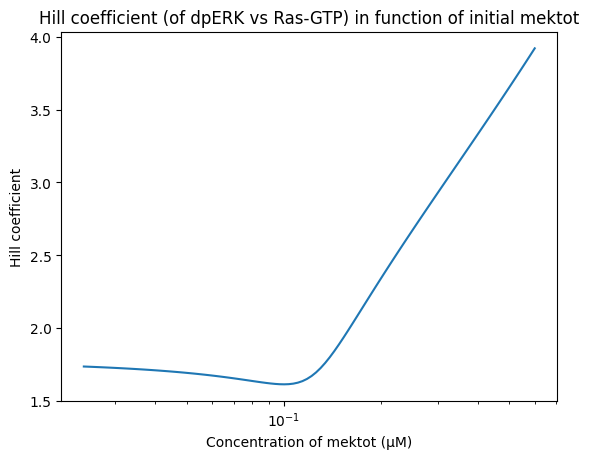

In [201]:
plt.plot(mekintervallog_new, nHlist_mek_loop_new)
plt.xlabel("Concentration of mektot (µM)")
plt.ylabel("Hill coefficient")
plt.title("Hill coefficient (of dpERK vs Ras-GTP) in function of initial mektot")
plt.xscale("log")

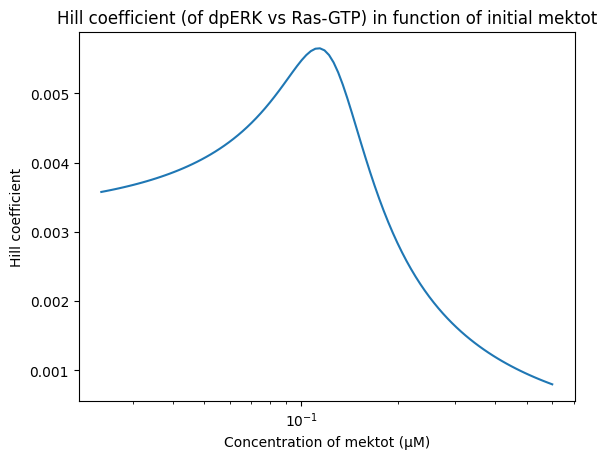

In [202]:
plt.plot(mekintervallog_new, Kmraslist_mek_loop_exp)
plt.xlabel("Concentration of mektot (µM)")
plt.ylabel("Hill coefficient")
plt.title("Hill coefficient (of dpERK vs Ras-GTP) in function of initial mektot")
plt.xscale("log")

In [203]:
new_mek_interval = find_new_interval(mekintervallog_new, nHlist_mek_loop_new)

In [204]:
new_mek_interval_list = new_mek_interval.tolist()

## Shifting ERK

In [205]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [180]:
dperk_values_erk_exp = []
for i in erkinterval_new:
    initial_values[9] = i
    params_rate[5] = i
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperktotv = Erk_ifo_erktot(dperk_values)  #division by erktot here, because it changes
    dperk_values_erk_exp.append(dperktotv)

In [439]:
np.savetxt('dperk_values_erk_exp.txt', dperk_values_erk_exp)

In [206]:
dperk_values_erk_exp_load = np.loadtxt('dperk_values_erk_exp.txt')

Text(0.5, 1.0, 'dpERK in function of Ras-GTP from the model')

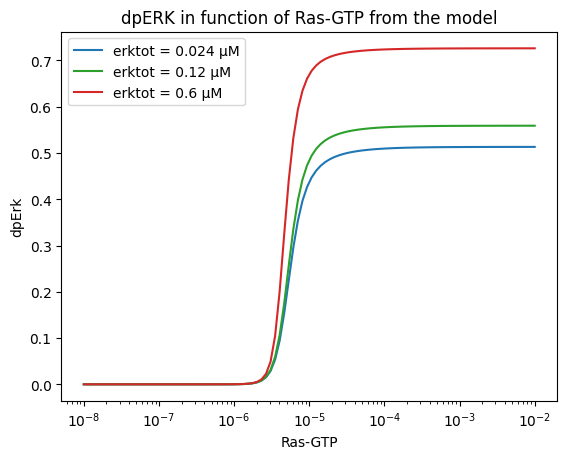

In [207]:
plt.plot(interval_values, dperk_values_erk_exp_load[0] ,'tab:blue', label = "erktot = {} µM".format(erkinterval_new[0]))
plt.plot(interval_values, dperk_values_erk_exp_load[1],"tab:green", label = "erktot = {} µM".format(erkinterval_new[1]))
plt.plot(interval_values, dperk_values_erk_exp_load[2],  "tab:red", label = "erktot = {} µM".format(erkinterval_new[2]))
plt.xlabel("Ras-GTP")
plt.ylabel("dpErk")
plt.xscale('log')
plt.legend()
plt.title("dpERK in function of Ras-GTP from the model")

In [208]:
nHlist_erk_exp = []
Kmlist_erk_exp = []
for i in dperk_values_erk_exp_load:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_erk_exp.append(coef[0])
    Kmlist_erk_exp.append(coef[1])


In [209]:
nHlist_erk_exp

[3.728499028715678, 3.888841092945111, 4.600195019977142]

Values of erk are still not low enough to give a Hill Coefficient of 2. We shall ignore ERK and let it be the usual interval.

## Shifting E2

In [210]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [185]:
dperk_values_e2_exp = []
for i in e2interval_new:
    params_rate[2] = i
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_e2_exp.append(dperk_values)

In [444]:
np.savetxt('dperk_values_e2_exp.txt', dperk_values_e2_exp)

In [211]:
dperk_values_e2_exp_load = np.loadtxt('dperk_values_e2_exp.txt')

In [212]:
dperktot_values_e2_exp = []
for lst in dperk_values_e2_exp_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_e2_exp.append(new_list)

Text(0.5, 1.0, 'dpERK in function of Ras-GTP from the model')

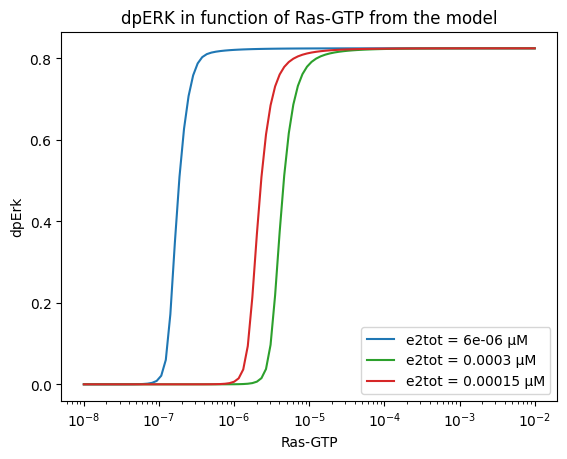

In [213]:
plt.plot(interval_values, dperktot_values_e2_exp[0] ,'tab:blue', label = "e2tot = {} µM".format(e2interval_new[0]))
plt.plot(interval_values, dperktot_values_e2_exp[1],"tab:green", label = "e2tot = {} µM".format(e2interval_new[1]))
plt.plot(interval_values, dperktot_values_e2_exp[2],  "tab:red", label = "e2tot = {} µM".format(e2interval_new[2]))
plt.xlabel("Ras-GTP")
plt.ylabel("dpErk")
plt.xscale('log')
plt.legend()
plt.title("dpERK in function of Ras-GTP from the model")

In [215]:
nHlist_e2_exp = []
Kmlist_e2_exp = []
for i in dperk_values_e2_exp_load:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_e2_exp.append(coef[0])
    Kmlist_e2_exp.append(coef[1])

In [216]:
nHlist_e2_exp

[5.927127614405192, 5.051846825842022, 5.044993814417625]

Values of e2 are still not low enough to give a Hill Coefficient of 2. We shall ignore E2 and let it be the usual interval.

## Shifting Mekpase

In [217]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [191]:
dperk_values_mekpase_exp = []
for i in mekpaseinterval_new:
    params_rate[4] = i
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_mekpase_exp.append(dperk_values)

In [447]:
np.savetxt('dperk_values_mekpase_exp.txt', dperk_values_mekpase_exp)

In [218]:
dperk_values_mekpase_exp_load = np.loadtxt('dperk_values_mekpase_exp.txt')

In [219]:
dperktot_values_mekpase_exp = []
for lst in dperk_values_mekpase_exp_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_mekpase_exp.append(new_list)

Text(0.5, 1.0, 'dpERK in function of Ras-GTP from the model')

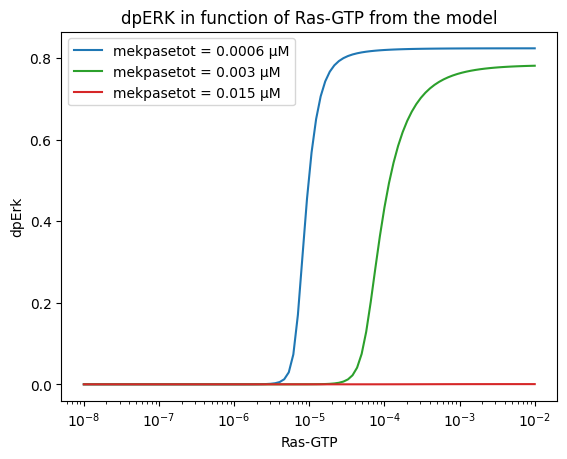

In [220]:
plt.plot(interval_values, dperktot_values_mekpase_exp[0] ,'tab:blue', label = "mekpasetot = {} µM".format(mekpaseinterval_new[0]))
plt.plot(interval_values, dperktot_values_mekpase_exp[1],"tab:green", label = "mekpasetot = {} µM".format(mekpaseinterval_new[1]))
plt.plot(interval_values, dperktot_values_mekpase_exp[2],  "tab:red", label = "mekpasetot = {} µM".format(mekpaseinterval_new[2]))
plt.xlabel("Ras-GTP")
plt.ylabel("dpErk")
plt.xscale('log')
plt.legend()
plt.title("dpERK in function of Ras-GTP from the model")

In [222]:
nHlist_mekpase_exp = []
Kmlist_mekpase_exp = []
for i in dperk_values_mekpase_exp_load:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_mekpase_exp.append(coef[0])
    Kmlist_mekpase_exp.append(coef[1])

In [223]:
nHlist_mekpase_exp

[4.797815980267343, 2.7108341886091702, 1.428868369976298]

In [224]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [197]:
dperk_values_mekpase_loop_exp = []
for i in mekpaseintervallog_new:
    dperk_values = []
    params_rate[4] = i
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_mekpase_loop_exp.append(dperk_values)

In [450]:
np.savetxt('dperk_values_mekpase_loop_exp.txt', dperk_values_mekpase_loop_exp)

In [225]:
dperk_values_mekpase_loop_exp_load = np.loadtxt('dperk_values_mekpase_loop_exp.txt')

In [228]:
dperktot_values_mekpase_loop_exp = []
for lst in dperk_values_mekpase_loop_exp_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_mekpase_loop_exp.append(new_list)

In [230]:
nHlist_mekpase_loop_exp = []
Kmlist_mekpase_loop_exp = []

for i in dperktot_values_mekpase_loop_exp:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_mekpase_loop_exp.append(coef[0])
    Kmlist_mekpase_loop_exp.append(coef[1])
    
Kmraslist_mekpase_loop_exp = Km_ifo_rastot(Kmlist_mekpase_loop_exp)

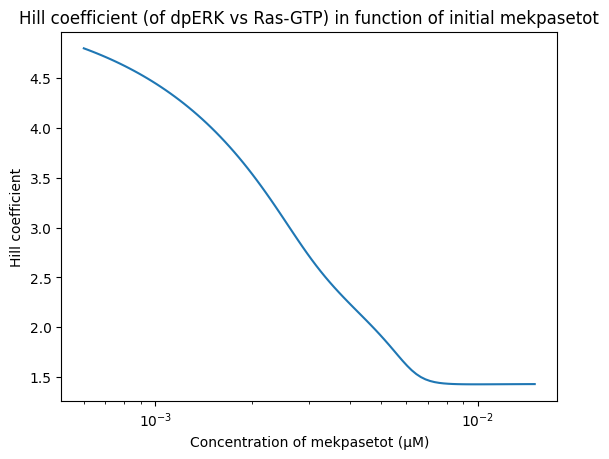

In [231]:
plt.plot(mekpaseintervallog_new, nHlist_mekpase_loop_exp)
plt.xlabel("Concentration of mekpasetot (µM)")
plt.ylabel("Hill coefficient")
plt.title("Hill coefficient (of dpERK vs Ras-GTP) in function of initial mekpasetot")
plt.xscale("log")

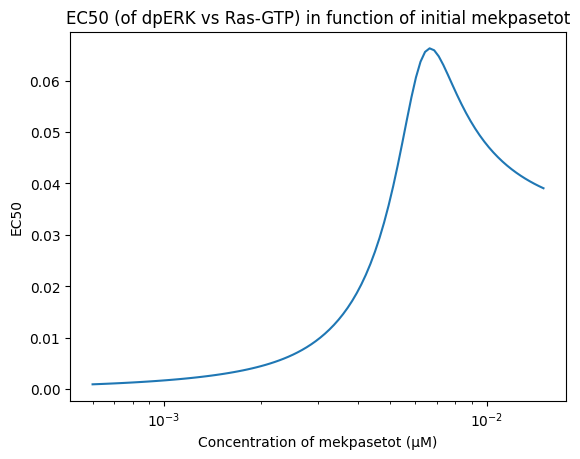

In [232]:
plt.plot(mekpaseintervallog_new, Kmraslist_mekpase_loop_exp)
plt.xlabel("Concentration of mekpasetot (µM)")
plt.ylabel("EC50")
plt.title("EC50 (of dpERK vs Ras-GTP) in function of initial mekpasetot")
plt.xscale("log")

In [233]:
nHlist_mekpase_loop_exp.reverse()
mekpaseintervallog_new_list = mekpaseintervallog_new.tolist()
mekpaseintervallog_new_list.reverse()
new_mekpase_interval = find_new_interval(mekpaseintervallog_new_list, nHlist_mekpase_loop_exp)
print(new_mekpase_interval)

[0.00644103 0.00644074 0.00644045 ... 0.00408608 0.00408589 0.00408571]


## Shifting Erkpase

In [234]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [204]:
dperk_values_erkpase_exp = []
for i in erkpaseinterval_new:
    params_rate[6] = i
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_erkpase_exp.append(dperk_values)

In [453]:
np.savetxt('dperk_values_erkpase_exp.txt', dperk_values_erkpase_exp)

In [235]:
dperk_values_erkpase_exp_load = np.loadtxt('dperk_values_erkpase_exp.txt')

In [236]:
dperktot_values_erkpase_exp = []
for lst in dperk_values_erkpase_exp_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_erkpase_exp.append(new_list)

Text(0.5, 1.0, 'dpERK in function of Ras-GTP from the model')

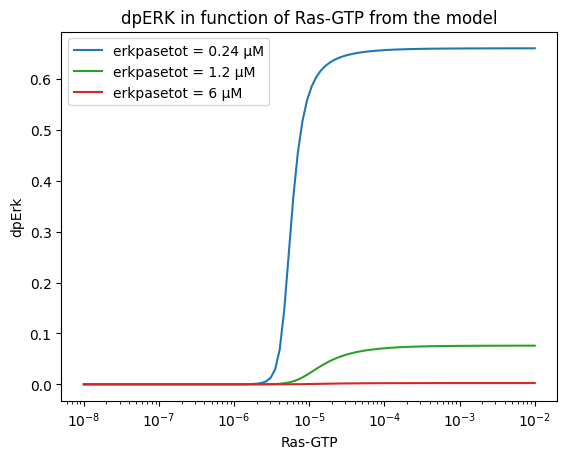

In [237]:
plt.plot(interval_values, dperktot_values_erkpase_exp[0] ,'tab:blue', label = "erkpasetot = {} µM".format(erkpaseinterval_new[0]))
plt.plot(interval_values, dperktot_values_erkpase_exp[1],"tab:green", label = "erkpasetot = {} µM".format(erkpaseinterval_new[1]))
plt.plot(interval_values, dperktot_values_erkpase_exp[2],  "tab:red", label = "erkpasetot = {} µM".format(erkpaseinterval_new[2]))
plt.xlabel("Ras-GTP")
plt.ylabel("dpErk")
plt.xscale('log')
plt.legend()
plt.title("dpERK in function of Ras-GTP from the model")

In [240]:
nHlist_erkpase_exp = []
Kmlist_erkpase_exp = []
for i in dperk_values_erkpase_exp_load:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_erkpase_exp.append(coef[0])
    Kmlist_erkpase_exp.append(coef[1])

In [241]:
nHlist_erkpase_exp

[4.529989650006612, 2.046364103540611, 1.7907047435709502]

In [242]:
#reset all parameters & initial_values to the basic ones:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [210]:
dperk_values_erkpase_loop_exp = []
for i in erkpaseintervallog_new:
    dperk_values = []
    params_rate[6] = i
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_erkpase_loop_exp.append(dperk_values)
    


In [456]:
np.savetxt('dperk_values_erkpase_loop_exp.txt', dperk_values_erkpase_loop_exp)

In [243]:
dperk_values_erkpase_loop_exp_load = np.loadtxt('dperk_values_erkpase_loop_exp.txt')

In [244]:
dperktot_values_erkpase_loop_exp = []
for lst in dperk_values_erkpase_loop_exp_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_erkpase_loop_exp.append(new_list)

In [245]:
nHlist_erkpase_loop_exp = []
Kmlist_erkpase_loop_exp = []

for i in dperktot_values_erkpase_loop_exp:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_erkpase_loop_exp.append(coef[0])
    Kmlist_erkpase_loop_exp.append(coef[1])
    
Kmraslist_erkpase_loop_exp = Km_ifo_rastot(Kmlist_erkpase_loop_exp)

Text(0.5, 1.0, 'Hill coefficient (of dpERK vs Ras-GTP) in function of initial erkpasetot')

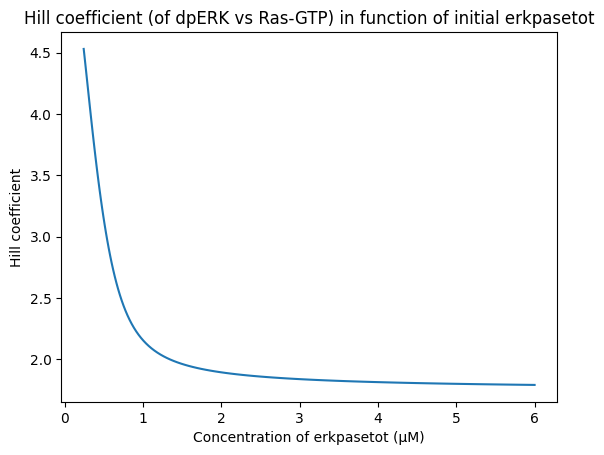

In [246]:
plt.plot(erkpaseintervallog_new, nHlist_erkpase_loop_exp)
plt.xlabel("Concentration of erkpasetot (µM)")
plt.ylabel("Hill coefficient")
plt.title("Hill coefficient (of dpERK vs Ras-GTP) in function of initial erkpasetot")


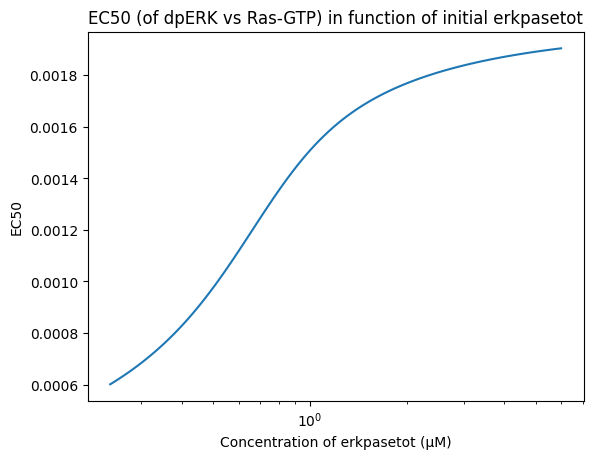

In [247]:
plt.plot(erkpaseintervallog_new, Kmraslist_erkpase_loop_exp)
plt.xlabel("Concentration of erkpasetot (µM)")
plt.ylabel("EC50")
plt.title("EC50 (of dpERK vs Ras-GTP) in function of initial erkpasetot")
plt.xscale("log")

In [248]:
nHlist_erkpase_loop_exp.reverse()
erkpaseintervallog_new_list = erkpaseintervallog_new.tolist()
erkpaseintervallog_new_list.reverse()
new_erkpase_interval = find_new_interval(erkpaseintervallog_new_list, nHlist_erkpase_loop_exp)
print(new_erkpase_interval)

[6.         5.99888802 5.99777624 ... 0.94067086 0.94049653 0.94032222]


In [249]:
new_mekpase_interval_list = new_mekpase_interval.tolist()
new_mekpase_interval_list.reverse()
new_erkpase_interval_list = new_erkpase_interval.tolist()
new_erkpase_interval_list.reverse()

## Shifting Km

In [250]:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [218]:
dperk_values_Km_exp = []
for i in Kminterval_new:
    k = 200
    d = k
    a = 2 * k / i
    params_rate[7] = a
    params_rate[8] = d
    params_rate[9] = k
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_Km_exp.append(dperk_values)

In [459]:
np.savetxt('dperk_values_Km_exp.txt', dperk_values_Km_exp)

In [251]:
dperk_values_Km_exp_load = np.loadtxt('dperk_values_Km_exp.txt')

In [252]:
dperktot_values_Km_exp = []
for lst in dperk_values_Km_exp_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_Km_exp.append(new_list)

Text(0.5, 1.0, 'dpERK in function of Ras-GTP from the model')

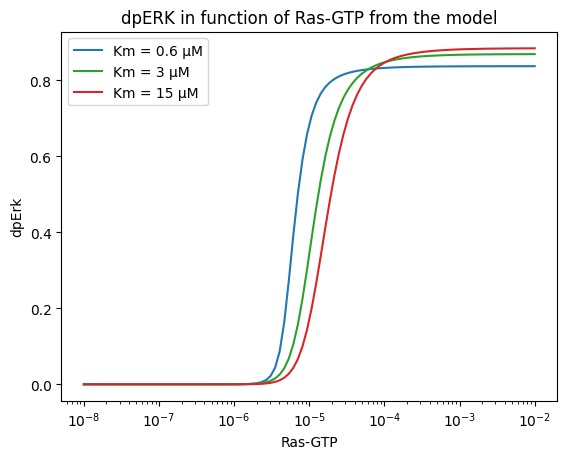

In [253]:
plt.plot(interval_values, dperktot_values_Km_exp[0] ,'tab:blue', label = "Km = {} µM".format(Kminterval_new[0]))
plt.plot(interval_values, dperktot_values_Km_exp[1],"tab:green", label = "Km = {} µM".format(Kminterval_new[1]))
plt.plot(interval_values, dperktot_values_Km_exp[2],  "tab:red", label = "Km = {} µM".format(Kminterval_new[2]))
plt.xlabel("Ras-GTP")
plt.ylabel("dpErk")
plt.xscale('log')
plt.legend()
plt.title("dpERK in function of Ras-GTP from the model")

In [255]:
nHlist_Km_exp = []
Kmlist_Km_exp = []
for i in dperk_values_Km_exp_load:
    coef, _ = curve_fit(Hill, interval_values, i)
    nHlist_Km_exp.append(coef[0])
    Kmlist_Km_exp.append(coef[1])

In [256]:
nHlist_Km_exp

[3.8551444517935374, 2.5921809714513406, 2.364750256633883]

In [257]:
params_rate = reset_parameters()
initial_values = reset_initial_values(params_rate)

In [224]:
dperk_values_Km_loop_exp = []
for i in Kmintervallog_new:
    k = 200
    d = k
    a = 2 * k / i
    params_rate[7] = a
    params_rate[8] = d
    params_rate[9] = k
    dperk_values = []
    for j in interval_values:
        params_rate[0] = j
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_Km_loop_exp.append(dperk_values)

In [462]:
np.savetxt('dperk_values_Km_loop_exp.txt', dperk_values_Km_loop_exp)

In [258]:
dperk_values_Km_loop_exp_load = np.loadtxt('dperk_values_Km_loop_exp.txt')

In [259]:
dperktot_values_Km_loop_exp = []
for lst in dperk_values_Km_loop_exp_load:
    new_list = Erk_ifo_erktot(lst)
    dperktot_values_Km_loop_exp.append(new_list)

In [261]:
nHlist_Km_loop_exp = []
Kmlist_Km_loop_exp = []

for i in dperktot_values_Km_loop_exp:
    coef, _ = curve_fit(Hill, interval_values, i, maxfev = 100000)
    nHlist_Km_loop_exp.append(coef[0])
    Kmlist_Km_loop_exp.append(coef[1])
    
Kmraslist_Km_loop_exp = Km_ifo_rastot(Kmlist_Km_loop_exp)

Text(0.5, 1.0, 'Hill coefficient (of dpERK vs Ras-GTP) in function of Km')

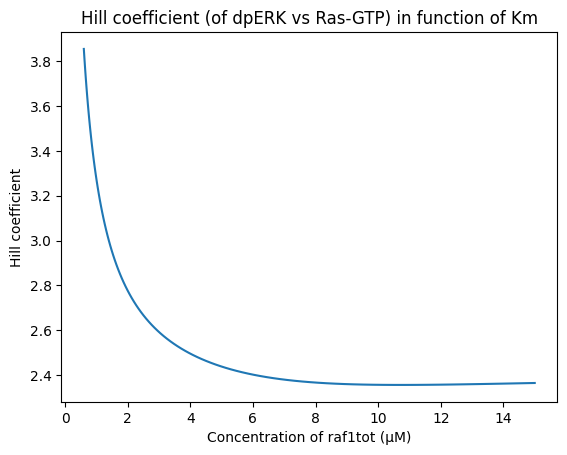

In [262]:
plt.plot(Kmintervallog_new, nHlist_Km_loop_exp)
plt.xlabel("Concentration of raf1tot (µM)")
plt.ylabel("Hill coefficient")
plt.title("Hill coefficient (of dpERK vs Ras-GTP) in function of Km")
#plt.xscale("log")

Text(0.5, 1.0, 'EC50 (of dpERK vs Ras-GTP) in function of Km')

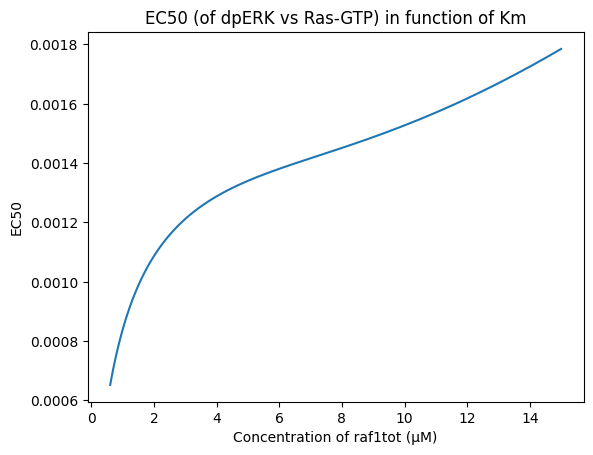

In [263]:
plt.plot(Kmintervallog_new, Kmraslist_Km_loop_exp)
plt.xlabel("Concentration of raf1tot (µM)")
plt.ylabel("EC50")
plt.title("EC50 (of dpERK vs Ras-GTP) in function of Km")
#plt.xscale("log")

In [264]:
nHlist_Km_loop_exp.reverse()
Kmintervallog_new_list = Kmintervallog_new.tolist()
Kmintervallog_new_list.reverse()
new_Km_interval = find_new_interval(Kmintervallog_new, nHlist_Km_loop_exp, left = 2.3, right = 2.4)



In [265]:
new_Km_interval_list = new_Km_interval.tolist()

In [266]:
new_raf1_interval_list = new_raf1_interval.tolist()
new_mek_interval_list = new_mek_interval.tolist()
new_Km_interval_list = new_Km_interval.tolist()

In [267]:
new_erkpase_interval_list = new_erkpase_interval.tolist()

In [268]:
new_mekpase_interval_list = new_erkpase_interval.tolist()

In [269]:
new_Km_interval = find_new_interval(Kmintervallog_new, nHlist_Km_loop_exp, left = 2.3, right = 2.4)

In [270]:
new_Km_interval_list = new_Km_interval.tolist()

In [271]:
N = 10000 #number of choices we can have

Km_interval_LHS_array_exp = np.logspace(np.log(0.006) / np.log(10) , np.log(15)/np.log(10), num = N)
mek_interval_LHS_array_exp = np.logspace((np.log(0.024) / np.log(10)) , np.log(60) / np.log(10), num = N)
erk_interval_LHS_array_exp = np.logspace((np.log(0.024) / np.log(10)) , np.log(60) / np.log(10), num = N)
raf1_interval_LHS_array_exp = np.logspace((np.log(0.0006) / np.log(10)) , np.log(0.15) / np.log(10), num = N)
e2_interval_LHS_array_exp = np.logspace((np.log(0.000006) / np.log(10)) , np.log(0.015) / np.log(10), num = N)
mekpase_interval_LHS_array_exp = np.logspace((np.log(0.00006) / np.log(10)) , np.log(0.015) / np.log(10), num = N)
erkpase_interval_LHS_array_exp = np.logspace((np.log(0.0024) / np.log(10)) , np.log(6) / np.log(10), num = N)

mek_interval_LHS_list_exp = mek_interval_LHS_array_exp.tolist()
erk_interval_LHS_list_exp = mek_interval_LHS_array_exp.tolist()
raf1_interval_LHS_list_exp = raf1_interval_LHS_array_exp.tolist()
e2_interval_LHS_list_exp = e2_interval_LHS_array_exp.tolist()
mekpase_interval_LHS_list_exp = mekpase_interval_LHS_array_exp.tolist()
erkpase_interval_LHS_list_exp = erkpase_interval_LHS_array_exp.tolist()
Km_interval_LHS_list_exp = Km_interval_LHS_array_exp.tolist()

In [272]:
new_mekpase_interval_list = new_mekpase_interval.tolist()

In [273]:
new_erkpase_interval_list = new_erkpase_interval.tolist()

In [274]:
new_Km_interval_list = new_Km_interval.tolist()

In [275]:
new_raf1_interval_list = new_raf1_interval.tolist()

In [276]:
new_mek_interval_list = new_mek_interval.tolist()

In [277]:
random_samples_exp = []

count = 0
while count < N: #make a list with 100 combinations of parameters. each value of a parameter can only be used once.
    count += 1
    #pick a random value of the interval
    mekvalue = random.choice(new_mek_interval_list)
    erkvalue = random.choice(erk_interval_LHS_list_exp) #remained the same
    raf1value = random.choice(new_raf1_interval_list)
    e2value = random.choice(e2_interval_LHS_list_exp) #remained the same
    mekpasevalue = random.choice(new_mekpase_interval_list)
    erkpasevalue = random.choice(new_erkpase_interval_list)
    kvalue = 200
    Kmvalue = random.choice(new_Km_interval_list)
    dvalue = kvalue  
    avalue = (2 * kvalue) / Kmvalue
    
    #delete it from the list
    new_mek_interval_list.remove(mekvalue)
    erk_interval_LHS_list_exp.remove(erkvalue)
    new_raf1_interval_list.remove(raf1value)
    e2_interval_LHS_list_exp.remove(e2value)
    new_mekpase_interval_list.remove(mekpasevalue)
    new_erkpase_interval_list.remove(erkpasevalue)
    new_Km_interval_list.remove(Kmvalue)
    
    #add values to the big list
    random_samples_exp.append([raf1value, e2value, mekvalue, mekpasevalue, erkvalue, erkpasevalue, avalue, dvalue, kvalue, Kmvalue])

In [278]:
np.savetxt('random_samples_exp.txt', random_samples_exp)

In [490]:
random_samples_exp_load = np.loadtxt('random_samples_exp.txt')

In [491]:
NN = 1000 #how many times we want to do it

dperk_values_LHS_exp = []
for i in range(NN):
    params_rate[1:] = random_samples_exp[i][0:9]
         
    initial_values[0] = random_samples_exp[i][0] #0 = raf1_0
    initial_values[4] = random_samples_exp[i][2] #4 = mek_0
    initial_values[9] = random_samples_exp[i][4] #9 = erk_0
        
    dperk_values = []
    for z in interval_values:
        params_rate[0] = z
        solutions = odeint(mapkmodel, initial_values, t, args=(params_rate,))
        dperk_values.append(solutions[:,14][-1])
    dperk_values_LHS_exp.append(dperk_values)

In [492]:
np.savetxt('dperk_values_LHS_exp.txt', dperk_values_LHS_exp)

In [279]:
dperk_values_LHS_exp_load = np.loadtxt('dperk_values_LHS_exp.txt')

In [280]:
from scipy.optimize import curve_fit

def model(x, a, b, c):
    return c*x**a/(x**a+b**a) 

def Hill_fit(z,x):
    yR= z/max(z) # normalize 
    popt, _ = curve_fit(model, x, yR, maxfev = 1000000)
    a,b,c = popt  
    return [round(a,8), round(b,8), round(c,8)]

In [281]:
nHlist_LHS_exp = []
Kmlist_LHS_exp = []
for i in dperk_values_LHS_exp_load:
    coefs = Hill_fit(i, interval_values)
    nHlist_LHS_exp.append(coefs[0])
    Kmlist_LHS_exp.append(coefs[1])
    
nHlist_LHS_prob_exp = []
for i in nHlist_LHS_exp:
    nHlist_LHS_prob_exp.append(i/100)
    
Kmlist_LHS_ras_exp = []
for i in Kmlist_LHS_exp:
    new_Km = i / interval_values[-1]
    Kmlist_LHS_ras_exp.append(new_Km)

In [282]:
#Check if all fits are "good"
def do_exp(i):
    a,b,c = Hill_fit(dperk_values_LHS_exp_load[i],interval_values)
    Fit_prova = model(interval_values, a,b,c)*max(dperk_values_LHS_exp_load[i]) 

    plt.plot(interval_values, dperk_values_LHS_exp_load[i])
    plt.plot(interval_values, Fit_prova, '--', label=f'Hill coeff= {np.round(a,2)}')
    plt.legend()
    plt.xscale('log')
    plt.xlabel('Rastot')
    plt.ylabel('dpErk')
    plt.show()

In [283]:
def probability_nH(nHlist, nHexpected, percentage):
    count_a = 0 #a) nH below nHexpected - nHexpected * percentage
    count_b = 0 #b) nH between nHexpected nHexpected * percentage and nHexpected + nHexpected * percentage
    count_c = 0 #c) nHexpected + nHexpected * percentage

    upper = nHexpected + nHexpected * percentage
    lower = nHexpected - nHexpected * percentage
    for i in nHlist:
        if i < lower :
            count_a += 1
        elif lower <= i <= upper:
            count_b += 1
        else:
            count_c += 1
            
    print("The probability of a Hill Coefficient below {} is {}\nThe probability of a Hill Coefficient between {} and {} is {} \nThe probability of a Hill Coefficient above {} is {}".format(lower, count_a/len(nHlist), lower, upper, count_b/len(nHlist), upper, count_c/len(nHlist)))

In [284]:
def probability_EC50(Kmlist, Kmexpected, percentage):
    count_a = 0
    count_b = 0
    count_c = 0
    
    upper = Kmexpected + (Kmexpected * percentage)
    lower = Kmexpected - Kmexpected * percentage
    
    for i in Kmlist:
        if i < lower:
            count_a += 1
        elif lower <= i <= upper:
            count_b += 1
        else:
            count_c += 1
    
    print("The probability of an EC50 below {} is {}\nThe probability of an EC50 between {} and {} is {} \nThe probability of an EC50 above {} is {}".format(lower, count_a/len(Kmlist), lower, upper, count_b/len(Kmlist), upper, count_c/len(Kmlist)))

In [285]:
probability_nH(nHlist_LHS_exp, 2, 0.2)

The probability of a Hill Coefficient below 1.6 is 0.556
The probability of a Hill Coefficient between 1.6 and 2.4 is 0.307 
The probability of a Hill Coefficient above 2.4 is 0.137


In [286]:
probability_EC50(Kmlist_LHS_ras_exp, 0.5, 0.2)

The probability of an EC50 below 0.4 is 0.678
The probability of an EC50 between 0.4 and 0.6 is 0.075 
The probability of an EC50 above 0.6 is 0.247


Text(0.5, 0, 'Hill Coefficient')

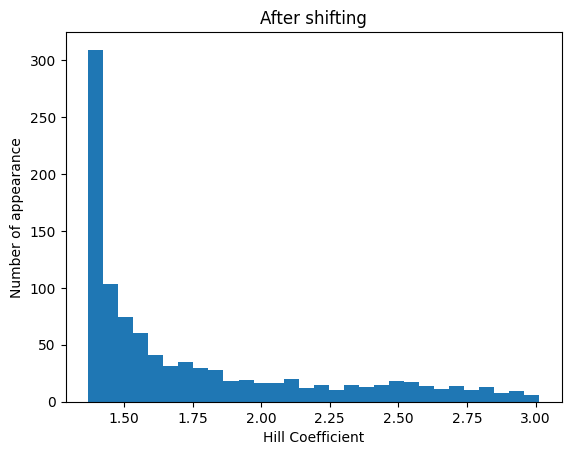

In [347]:
plt.hist(nHlist_LHS_exp, density = False, bins = 30)
plt.title('After shifting')
plt.ylabel('Number of appearance')
plt.xlabel('Hill Coefficient')

Text(0, 0.5, 'Number of appearance')

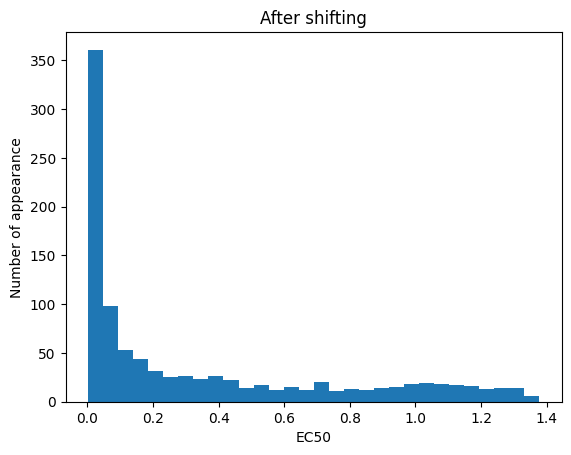

In [348]:
plt.hist(Kmlist_LHS_ras_exp, density = False, bins = 30)
plt.title("After shifting")
plt.xlabel("EC50")
plt.ylabel("Number of appearance")

In [290]:
paramdict = {"raf1":0, "mek":1, "erk":2, "e2":3, "mekpase":4, "erkpase":5, "Km":6} 
xparam = [paramdict["raf1"], paramdict["mek"], paramdict["erk"], paramdict["e2"], paramdict["mekpase"], paramdict["erkpase"], paramdict["Km"]]
namesparam = ["RAF1", "MEK", "ERK", "E2", "MEKP'ase", "ERKP'ase", "Km"]
paramslist_nH_exp = [nHlist_raf1_exp, nHlist_mek_exp, nHlist_erk_exp, nHlist_e2_exp, nHlist_mekpase_exp, nHlist_erkpase_exp, nHlist_Km_exp]

heightlist_nH_exp = []
for i in paramslist_nH_exp:
    heightlist_nH_exp.append(max(i) - min(i))
    
minlist_nH_exp = []
for i in paramslist_nH_exp:
    minlist_nH_exp.append(min(i))

Text(0.5, 1.0, 'After shifting')

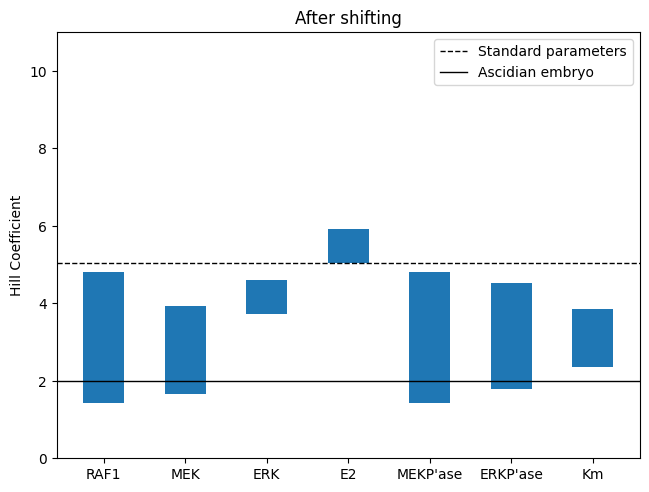

In [291]:
plt.bar(xparam, heightlist_nH_exp, width = 0.5, bottom = minlist_nH_exp)
plt.ylim([0, 11])
plt.xticks(xparam, namesparam)
plt.tight_layout()
plt.ylabel("Hill Coefficient")
plt.axhline(y = 5.05, linestyle = "--", linewidth = 1, color = "k", label = "Standard parameters")
plt.axhline(y = 2, linestyle = "-", linewidth = 1, color = "k", label = "Ascidian embryo")
plt.legend()
plt.title("After shifting")

In [292]:
new_Km_interval

array([0.6       , 0.60005463, 0.60010927, ..., 1.49090214, 1.49103789,
       1.49117366])